In [2]:
import json
import os
import pandas as pd
from research.utils.data_access_utils import S3AccessUtils
from report_generation.report_generator import generate_ts_data, SamplingFilter
from research.utils.datetime_utils import add_days
from report_generation.report_generator import gen_pm_base
from population_metrics.smart_metrics import generate_smart_avg_weight, generate_smart_individual_values, ValidationError
from filter_optimization.filter_optimization_task import _add_date_hour_columns
from research.weight_estimation.keypoint_utils.optics import pixel2world
import numpy as np

pd.set_option('display.max_rows', 500)

In [3]:
s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))

In [4]:
cohort_names = [
    'seglberget_pen_id_66_2020-05-13_2020-06-13',
    'bolaks_pen_id_88_2020-02-28_2020-03-10',
    'langoy_pen_id_108_2020-05-07_2020-05-17',
    'tittelsnes_pen_id_37_2020-06-10_2020-06-24',
    'aplavika_pen_id_95_2020-07-10_2020-07-26',
#     'kjeppevikholmen_pen_id_5_2019-06-18_2019-07-02',
    'silda_pen_id_86_2020-07-02_2020-07-19',
    'vikane_pen_id_60_2020-08-10_2020-08-30',
    'eldviktaren_pen_id_164_2020-09-21_2020-10-08',
#     'habranden_pen_id_100_2020-08-10_2020-08-31',
    'varholmen_pen_id_131_2020-08-15_2020-08-30',
    'dale_pen_id_143_2020-10-07_2020-10-21',
    'djubawik_pen_id_153_2020-11-10_2020-11-26',
    'leivsethamran_pen_id_165_2020-10-18_2020-11-13',
    'movikodden_pen_id_114_2020-11-03_2020-11-25',
    'movikodden_pen_id_167_2020-10-13_2020-10-30',
    'slapoya_pen_id_116_2020-10-18_2020-11-08',
    'varholmen_pen_id_131_2020-08-15_2020-08-30',
    'varholmen_pen_id_151_2020-10-02_2020-10-17',
    'varholmen_pen_id_186_2020-10-18_2020-11-02'
]

cohort_names2 = [
    'dale_pen_id_144_2020-12-20_2021-01-11'
]

In [5]:
camera_type = {
    'seglberget_pen_id_66_2020-05-13_2020-06-13': 'sexton',
    'bolaks_pen_id_88_2020-02-28_2020-03-10': 'sexton',
    'langoy_pen_id_108_2020-05-07_2020-05-17': 'sexton',
    'tittelsnes_pen_id_37_2020-06-10_2020-06-24': 'sexton',
    'aplavika_pen_id_95_2020-07-10_2020-07-26': 'sexton',
#     'kjeppevikholmen_pen_id_5_2019-06-18_2019-07-02': 'sexton',
    'silda_pen_id_86_2020-07-02_2020-07-19': 'sexton',
    'vikane_pen_id_60_2020-08-10_2020-08-30': 'atlas',
    'eldviktaren_pen_id_164_2020-09-21_2020-10-08': 'atlas',
#     'habranden_pen_id_100_2020-08-10_2020-08-31': 'imenco',
    'varholmen_pen_id_131_2020-08-15_2020-08-30': 'imenco',
    'dale_pen_id_143_2020-10-07_2020-10-21': 'atlas',
    'djubawik_pen_id_153_2020-11-10_2020-11-26': 'atlas',
    'leivsethamran_pen_id_165_2020-10-18_2020-11-13': 'atlas',
    'movikodden_pen_id_114_2020-11-03_2020-11-25': 'imenco',
    'movikodden_pen_id_167_2020-10-13_2020-10-30': 'imenco',
    'slapoya_pen_id_116_2020-10-18_2020-11-08': 'imenco',
    'varholmen_pen_id_131_2020-08-15_2020-08-30': 'imenco',
    'varholmen_pen_id_151_2020-10-02_2020-10-17': 'imenco',
    'varholmen_pen_id_186_2020-10-18_2020-11-02': 'atlas',
    
    
    'dale_pen_id_144_2020-12-20_2021-01-11': 'atlas'
}

In [20]:
batch_name = 'test'

ROOT_DIR = '/root/data/alok/biomass_estimation/playground'
dfs, gt_metadatas = {}, {}
for cohort_name in cohort_names:
    s3_dir = os.path.join(
        'https://aquabyte-images-adhoc.s3-eu-west-1.amazonaws.com/alok/production_datasets',
        cohort_name
    )

    ground_truth_metadata_url = os.path.join(s3_dir, 'ground_truth_metadata.json')
    ground_truth_key_base = os.path.join(batch_name, cohort_name, 'ground_truth_metadata.json')
#     ground_truth_metadata_url = os.path.join(s3_dir, 'ground_truth_metadata_validated.json')
#     ground_truth_key_base = os.path.join(batch_name, cohort_name, 'ground_truth_metadata_validated.json')
    ground_truth_f = os.path.join(ROOT_DIR, ground_truth_key_base)
    print(ground_truth_metadata_url)
    s3.download_from_url(ground_truth_metadata_url, custom_location=ground_truth_f)
    gt_metadata = json.load(open(ground_truth_f))
    gt_metadatas[cohort_name] = gt_metadata
    
    data_url = os.path.join(s3_dir, 'annotation_dataset.csv')
    data_f, _, _= s3.download_from_url(data_url)
    df = pd.read_csv(data_f)
    df = _add_date_hour_columns(df)
    dfs[cohort_name] = df
    
    

https://aquabyte-images-adhoc.s3-eu-west-1.amazonaws.com/alok/production_datasets/seglberget_pen_id_66_2020-05-13_2020-06-13/ground_truth_metadata.json
https://aquabyte-images-adhoc.s3-eu-west-1.amazonaws.com/alok/production_datasets/bolaks_pen_id_88_2020-02-28_2020-03-10/ground_truth_metadata.json
https://aquabyte-images-adhoc.s3-eu-west-1.amazonaws.com/alok/production_datasets/langoy_pen_id_108_2020-05-07_2020-05-17/ground_truth_metadata.json
https://aquabyte-images-adhoc.s3-eu-west-1.amazonaws.com/alok/production_datasets/tittelsnes_pen_id_37_2020-06-10_2020-06-24/ground_truth_metadata.json
https://aquabyte-images-adhoc.s3-eu-west-1.amazonaws.com/alok/production_datasets/aplavika_pen_id_95_2020-07-10_2020-07-26/ground_truth_metadata.json
https://aquabyte-images-adhoc.s3-eu-west-1.amazonaws.com/alok/production_datasets/silda_pen_id_86_2020-07-02_2020-07-19/ground_truth_metadata.json
https://aquabyte-images-adhoc.s3-eu-west-1.amazonaws.com/alok/production_datasets/vikane_pen_id_60_202

<h1> Generate old / new model weights </h1>

In [7]:

    
"""This module contains utility helper functions for the WeightEstimator class."""

from collections import namedtuple
from typing import Dict, List, Tuple
import numpy as np
import torch
from research.weight_estimation.keypoint_utils import body_parts


CameraMetadata = namedtuple('CameraMetadata',
                            ['focal_length', 'focal_length_pixel', 'baseline_m',
                             'pixel_count_width', 'pixel_count_height', 'image_sensor_width',
                             'image_sensor_height'])


def get_left_right_keypoint_arrs(annotation: Dict[str, List[Dict]]) -> Tuple:
    """Gets numpy array of left and right keypoints given input keypoint annotation.
    Args:
        annotation: dict with keys 'leftCrop' and 'rightCrop'. Values are lists where each element
        is a dict with keys 'keypointType', 'xCrop' (num pixels from crop left edge),
        'yCrop' (num pixels from crop top edge), 'xFrame' (num pixels from full frame left edge),
        and 'yFrame' (num pixels from full frame top edge).
    Returns:
        X_left: numpy array containing left crop (xFrame, yFrame) for each key-point ordered
        alphabetically.
        X_right: same as above, but for right crop.
    """

    left_keypoints, right_keypoints = {}, {}
    for item in annotation['leftCrop']:
        body_part = item['keypointType']
        left_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    for item in annotation['rightCrop']:
        body_part = item['keypointType']
        right_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    left_keypoint_arr, right_keypoint_arr = [], []
    for body_part in body_parts.core_body_parts:
        left_keypoint_arr.append(left_keypoints[body_part])
        right_keypoint_arr.append(right_keypoints[body_part])

    X_left = np.array(left_keypoint_arr)
    X_right = np.array(right_keypoint_arr)
    return X_left, X_right


def normalize_left_right_keypoint_arrs(X_left: np.ndarray, X_right: np.ndarray) -> Tuple:
    """Normalizes input left and right key-point arrays. The normalization involves (1) 2D
    translation of all keypoints such that they are centered, (2) rotation of the 2D coordiantes
    about the center such that the line passing through UPPER_LIP and fish center is horizontal.
    """

    # translate key-points, perform reflection if necessary
    upper_lip_idx = body_parts.core_body_parts.index(body_parts.UPPER_LIP)
    tail_notch_idx = body_parts.core_body_parts.index(body_parts.TAIL_NOTCH)
    if X_left[upper_lip_idx, 0] > X_left[tail_notch_idx, 0]:
        X_center = 0.5 * (np.max(X_left, axis=0) + np.min(X_left, axis=0))
        X_left_centered = X_left - X_center
        X_right_centered = X_right - X_center
    else:
        X_center = 0.5 * (np.max(X_right, axis=0) + np.min(X_right, axis=0))
        X_left_centered = X_right - X_center
        X_right_centered = X_left - X_center
        X_left_centered[:, 0] = -X_left_centered[:, 0]
        X_right_centered[:, 0] = -X_right_centered[:, 0]

    # rotate key-points
    upper_lip_x, upper_lip_y = tuple(X_left_centered[upper_lip_idx])
    theta = np.arctan(upper_lip_y / upper_lip_x)
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    D = X_left_centered - X_right_centered
    X_left_rot = np.dot(X_left_centered, R)
    X_right_rot = X_left_rot - D
    return X_left_rot, X_right_rot


def convert_to_world_point_arr(X_left: np.ndarray, X_right: np.ndarray,
                               camera_metadata: CameraMetadata) -> np.ndarray:
    """Converts input left and right normalized keypoint arrays into world coordinate array."""

    y_world = camera_metadata.focal_length_pixel * camera_metadata.baseline_m / \
              (X_left[:, 0] - X_right[:, 0])

    # Note: the lines commented out below are technically the correct formula for conversion
    # x_world = X_left[:, 0] * y_world / camera_metadata.focal_length_pixel
    # z_world = -X_left[:, 1] * y_world / camera_metadata.focal_length_pixel
    x_world = ((X_left[:, 0] * camera_metadata.image_sensor_width / camera_metadata.pixel_count_width) * y_world) / (camera_metadata.focal_length)
    z_world = (-(X_left[:, 1] * camera_metadata.image_sensor_height / camera_metadata.pixel_count_height) * y_world) / (camera_metadata.focal_length)
    X_world = np.vstack([x_world, y_world, z_world]).T
    return X_world


def stabilize_keypoints(X: np.ndarray) -> np.ndarray:
    """Transforms world coordinate array so that neural network inputs are stabilized"""
    X_new = np.zeros(X.shape)
    X_new[:, 0] = 0.5 * X[:, 0] / X[:, 1]
    X_new[:, 1] = 0.5 * X[:, 2] / X[:, 1]
    X_new[:, 2] = 0.05 / X[:, 1]
    return X_new


def convert_to_nn_input(annotation: Dict[str, List[Dict]], camera_metadata: CameraMetadata) \
        -> torch.Tensor:
    """Convrts input keypoint annotation and camera metadata into neural network tensor input."""
    X_left, X_right = get_left_right_keypoint_arrs(annotation)
    X_left_norm, X_right_norm = normalize_left_right_keypoint_arrs(X_left, X_right)
    X_world = convert_to_world_point_arr(X_left_norm, X_right_norm, camera_metadata)
    X = stabilize_keypoints(X_world)
    nn_input = torch.from_numpy(np.array([X])).float()
    return nn_input


"""
This module contains the WeightEstimator class for estimating fish weight (g), length (mm), and
k-factor given input keypoint coordinates and camera metadata.
"""

from typing import Dict, Tuple
import torch
from torch import nn


class Network(nn.Module):
    """Network class defines neural-network architecture for both weight and k-factor estimation
    (currently both neural networks share identical architecture)."""

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """Run inference on input keypoint tensor."""
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x


class WeightEstimator:
    """WeightEstimator class is used to predict fish weight, k-factor, and length
    given input keypoint annotations and camera metadata."""

    def __init__(self, weight_model_f: str, kf_model_f: str) -> None:
        """Initializes class with input weight and k-factor neural-networks."""
        self.weight_model = Network()
        self.weight_model.load_state_dict(torch.load(weight_model_f))
        self.weight_model.eval()

        self.kf_model = Network()
        self.kf_model.load_state_dict(torch.load(kf_model_f))
        self.kf_model.eval()

    @staticmethod
    def _get_model_input(annotation: Dict, camera_metadata: CameraMetadata) -> torch.Tensor:
        """Generates neural-network input tensor given annotation and camera_metadata."""
        X = convert_to_nn_input(annotation, camera_metadata)
        return X

    def predict_weight(self, annotation: Dict, camera_metadata: CameraMetadata) -> float:
        """Generates weight prediction given input annotation and camera metadata."""
        X = self._get_model_input(annotation, camera_metadata)
        weight = 1e4 * self.weight_model(X).item()
        return weight

    def predict_kf(self, annotation: Dict, camera_metadata: CameraMetadata) -> float:
        """Generates k-factor prediction gievn input annotation and camera metadata."""
        X = self._get_model_input(annotation, camera_metadata)
        kf = self.kf_model(X).item()
        return kf

    def predict(self, annotation: Dict, camera_metadata: CameraMetadata) -> Tuple:
        """Generates weight, k-factor, and length predictions given input annotation and camera
        metadata."""
        weight = self.predict_weight(annotation, camera_metadata)
        kf = self.predict_kf(annotation, camera_metadata)
        if weight * kf > 0:
            length = (1e5 * weight / kf) ** (1.0 / 3)
        else:
            length = 0
        return weight, length, kf

# Start here

In [8]:
models = [
#     ('weight_v1', 'curr-nonsynthetic', 'https://aquabyte-models.s3-us-west-1.amazonaws.com/biomass/playground/nn_epoch_798_v2.pb', True),
    ('weight_v2', 'curr-synthetic', 'https://aquabyte-models.s3-us-west-1.amazonaws.com/biomass/trained_models/2020-11-27T00-00-00/weight_model_synthetic_data.pb', True),
#     ('weight_v3', 'nojitter-ols', '/root/data/alok/biomass_estimation/playground/output_model_bryton.pb', False),
#     ('weight_v4', 'jitter-ols', '/root/data/alok/biomass_estimation/playground/output_model_bryton2.pb', False),
#     ('weight_v5', 'jitter-nools', '/root/data/alok/biomass_estimation/playground/output_model_bryton3.pb', False),
#     ('weight_v6', 'augV1-ols', '/root/data/alok/biomass_estimation/playground/output_model_bryton4.pb', False),
#     ('weight_v7', 'augV1-nools', '/root/data/alok/biomass_estimation/playground/output_model_bryton5.pb', False),
#     ('weight_v8', 'augV2-ols', '/root/data/alok/biomass_estimation/playground/output_model_bryton6.pb', False),
#     ('weight_v9', 'augV3-ols', '/root/data/alok/biomass_estimation/playground/output_model_bryton7.pb', False),
#     ('weight_v10', 'augV1-bidir-ols', '/root/data/alok/biomass_estimation/playground/output_model_bryton8.pb', False),
#     ('weight_v11', 'augV2-ols-akpd', '/root/data/alok/biomass_estimation/playground/output_model_bryton9.pb', False),
#     ('weight_v12', 'augV1-ols-akpd-halfinfl', '/root/data/alok/biomass_estimation/playground/output_model_bryton10.pb', False),
#     ('weight_v13', 'augV2-ols-akpd-halfinfl', '/root/data/alok/biomass_estimation/playground/output_model_bryton11.pb', False),
#     ('weight_v14', 'augV3-o-a-h-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton12.pb', False),
#     ('weight_v15', 'augV4-o-a-h-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton13.pb', False),
#     ('weight_v16', 'augV4-a-h-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton14.pb', False),
#     ('weight_v17', 'augV4-o-a-h2-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton15.pb', False),
#     ('weight_v18', 'augV4-o-a-h3-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton16.pb', False),
#     ('weight_v19', 'augV4-o-a-h4-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton17.pb', False),
#     ('weight_v20', 'augV4-o-a-h5-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton18.pb', False),
#     ('weight_v21', 'augV4-j2-o-a-h-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton19.pb', False),
#     ('weight_v22', 'augV4-j3-o-a-h-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton20.pb', False),
#     ('weight_v23', 'augV4-j4-o-a-h-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton21.pb', False),
#     ('weight_v24', 'augV4-o-a-h-99#2', '/root/data/alok/biomass_estimation/playground/output_model_bryton22.pb', False),
#     ('weight_v25', 'noaugV4-o-a-h-99', '/root/data/alok/biomass_estimation/playground/output_model_bryton23.pb', False),
#     ('weight_v26', 'augV4-j2-o-a-h-99#2', '/root/data/alok/biomass_estimation/playground/output_model_bryton24.pb', False),
#     ('weight_v27', 'augV1-alokj-o-a-h-99#2', '/root/data/alok/biomass_estimation/playground/output_model_bryton_a1.pb', False),
#     ('weight_v28', 'augV1-alokj-o-a-h-99-t', '/root/data/alok/biomass_estimation/playground/output_model_bryton_a2.pb', False),
#     ('weight_v29', 'augV1-alokj-o-a-h-90', '/root/data/alok/biomass_estimation/playground/output_model_bryton_a3.pb', False),
#     ('weight_v30', 'augV1-o-o-a-h-90', '/root/data/alok/biomass_estimation/playground/output_model_bryton_a4.pb', False),
#     ('weight_v31', 'augV4-alokj-o-a-h-90', '/root/data/alok/biomass_estimation/playground/output_model_bryton_a5.pb', False),
#     ('weight_v32', 'augV4-o-a-h-90', '/root/data/alok/biomass_estimation/playground/output_model_bryton_a6.pb', False)
]

# additional_models = [
#     ('weight_v31', 'augV4-alokj-o-a-h-90', '/root/data/alok/biomass_estimation/playground/output_model_bryton_a5.pb', False),
#     ('weight_v32', 'augV4-o-a-h-90', '/root/data/alok/biomass_estimation/playground/output_model_bryton_a6.pb', False)
# ]

In [25]:
for key, tag, model_url, is_url in models:
    # weight_model_f, _, _ = s3.download_from_url('https://aquabyte-models.s3-us-west-1.amazonaws.com/biomass/trained_models/2020-11-27T00-00-00/weight_model_synthetic_data.pb')
    if is_url:
        weight_model_f, _, _ = s3.download_from_url(model_url)
    else:
        weight_model_f = model_url
    kf_model_f, _, _ = s3.download_from_url('https://aquabyte-models.s3-us-west-1.amazonaws.com/k-factor/playground/kf_predictor_v2.pb')

    weight_estimator = WeightEstimator(weight_model_f, kf_model_f)


    for k, rdf in dfs.items():
        print(k)
        weights = []
        count = 0
        for idx, row in rdf.iterrows():
            if count % 100 == 0:
                print('Percentage completion: {}%'.format(round(100 * count / rdf.shape[0], 2)))
                print(count)
            count += 1
            annotation = json.loads(row.annotation.replace("'", '"'))
            if not annotation:
                weights.append(None)
                continue
            camera_metadata = json.loads(row.camera_metadata.replace("'", '"'))
            if not camera_metadata:
                camera_metadata = json.loads(rdf.camera_metadata.iloc[0].replace("'", '"'))

            camera_metadata_obj = CameraMetadata(
                focal_length=camera_metadata['focalLength'],
                focal_length_pixel=camera_metadata['focalLengthPixel'],
                baseline_m=camera_metadata['baseline'],
                pixel_count_width=camera_metadata['pixelCountWidth'],
                pixel_count_height=camera_metadata['pixelCountHeight'],
                image_sensor_width=camera_metadata['imageSensorWidth'],
                image_sensor_height=camera_metadata['imageSensorHeight']
            )

            weight, length, kf = weight_estimator.predict(annotation, camera_metadata_obj)
            weights.append(weight)
        rdf[key] = weights


seglberget_pen_id_66_2020-05-13_2020-06-13
Percentage completion: 0.0%
0
Percentage completion: 0.94%
100
Percentage completion: 1.88%
200
Percentage completion: 2.82%
300
Percentage completion: 3.76%
400
Percentage completion: 4.7%
500
Percentage completion: 5.64%
600
Percentage completion: 6.58%
700
Percentage completion: 7.52%
800
Percentage completion: 8.46%
900
Percentage completion: 9.4%
1000
Percentage completion: 10.34%
1100
Percentage completion: 11.28%
1200
Percentage completion: 12.22%
1300
Percentage completion: 13.16%
1400
Percentage completion: 14.1%
1500
Percentage completion: 15.04%
1600
Percentage completion: 15.98%
1700
Percentage completion: 16.93%
1800
Percentage completion: 17.87%
1900
Percentage completion: 18.81%
2000
Percentage completion: 19.75%
2100
Percentage completion: 20.69%
2200
Percentage completion: 21.63%
2300
Percentage completion: 22.57%
2400
Percentage completion: 23.51%
2500
Percentage completion: 24.45%
2600
Percentage completion: 25.39%
2700
Perc

Percentage completion: 40.47%
12700
Percentage completion: 40.79%
12800
Percentage completion: 41.11%
12900
Percentage completion: 41.43%
13000
Percentage completion: 41.74%
13100
Percentage completion: 42.06%
13200
Percentage completion: 42.38%
13300
Percentage completion: 42.7%
13400
Percentage completion: 43.02%
13500
Percentage completion: 43.34%
13600
Percentage completion: 43.66%
13700
Percentage completion: 43.97%
13800
Percentage completion: 44.29%
13900
Percentage completion: 44.61%
14000
Percentage completion: 44.93%
14100
Percentage completion: 45.25%
14200
Percentage completion: 45.57%
14300
Percentage completion: 45.89%
14400
Percentage completion: 46.2%
14500
Percentage completion: 46.52%
14600
Percentage completion: 46.84%
14700
Percentage completion: 47.16%
14800
Percentage completion: 47.48%
14900
Percentage completion: 47.8%
15000
Percentage completion: 48.12%
15100
Percentage completion: 48.44%
15200
Percentage completion: 48.75%
15300
Percentage completion: 49.07%
1

Percentage completion: 75.8%
4300
Percentage completion: 77.56%
4400
Percentage completion: 79.32%
4500
Percentage completion: 81.09%
4600
Percentage completion: 82.85%
4700
Percentage completion: 84.61%
4800
Percentage completion: 86.37%
4900
Percentage completion: 88.14%
5000
Percentage completion: 89.9%
5100
Percentage completion: 91.66%
5200
Percentage completion: 93.42%
5300
Percentage completion: 95.19%
5400
Percentage completion: 96.95%
5500
Percentage completion: 98.71%
5600
tittelsnes_pen_id_37_2020-06-10_2020-06-24
Percentage completion: 0.0%
0
Percentage completion: 0.95%
100
Percentage completion: 1.9%
200
Percentage completion: 2.85%
300
Percentage completion: 3.8%
400
Percentage completion: 4.76%
500
Percentage completion: 5.71%
600
Percentage completion: 6.66%
700
Percentage completion: 7.61%
800
Percentage completion: 8.56%
900
Percentage completion: 9.51%
1000
Percentage completion: 10.46%
1100
Percentage completion: 11.41%
1200
Percentage completion: 12.37%
1300
Perce

Percentage completion: 42.5%
11400
Percentage completion: 42.88%
11500
Percentage completion: 43.25%
11600
Percentage completion: 43.62%
11700
Percentage completion: 44.0%
11800
Percentage completion: 44.37%
11900
Percentage completion: 44.74%
12000
Percentage completion: 45.11%
12100
Percentage completion: 45.49%
12200
Percentage completion: 45.86%
12300
Percentage completion: 46.23%
12400
Percentage completion: 46.61%
12500
Percentage completion: 46.98%
12600
Percentage completion: 47.35%
12700
Percentage completion: 47.72%
12800
Percentage completion: 48.1%
12900
Percentage completion: 48.47%
13000
Percentage completion: 48.84%
13100
Percentage completion: 49.22%
13200
Percentage completion: 49.59%
13300
Percentage completion: 49.96%
13400
Percentage completion: 50.33%
13500
Percentage completion: 50.71%
13600
Percentage completion: 51.08%
13700
Percentage completion: 51.45%
13800
Percentage completion: 51.83%
13900
Percentage completion: 52.2%
14000
Percentage completion: 52.57%
14

Percentage completion: 31.12%
7700
Percentage completion: 31.53%
7800
Percentage completion: 31.93%
7900
Percentage completion: 32.34%
8000
Percentage completion: 32.74%
8100
Percentage completion: 33.14%
8200
Percentage completion: 33.55%
8300
Percentage completion: 33.95%
8400
Percentage completion: 34.36%
8500
Percentage completion: 34.76%
8600
Percentage completion: 35.17%
8700
Percentage completion: 35.57%
8800
Percentage completion: 35.97%
8900
Percentage completion: 36.38%
9000
Percentage completion: 36.78%
9100
Percentage completion: 37.19%
9200
Percentage completion: 37.59%
9300
Percentage completion: 38.0%
9400
Percentage completion: 38.4%
9500
Percentage completion: 38.8%
9600
Percentage completion: 39.21%
9700
Percentage completion: 39.61%
9800
Percentage completion: 40.02%
9900
Percentage completion: 40.42%
10000
Percentage completion: 40.82%
10100
Percentage completion: 41.23%
10200
Percentage completion: 41.63%
10300
Percentage completion: 42.04%
10400
Percentage complet

Percentage completion: 18.1%
6100
Percentage completion: 18.39%
6200
Percentage completion: 18.69%
6300
Percentage completion: 18.99%
6400
Percentage completion: 19.28%
6500
Percentage completion: 19.58%
6600
Percentage completion: 19.88%
6700
Percentage completion: 20.18%
6800
Percentage completion: 20.47%
6900
Percentage completion: 20.77%
7000
Percentage completion: 21.07%
7100
Percentage completion: 21.36%
7200
Percentage completion: 21.66%
7300
Percentage completion: 21.96%
7400
Percentage completion: 22.25%
7500
Percentage completion: 22.55%
7600
Percentage completion: 22.85%
7700
Percentage completion: 23.14%
7800
Percentage completion: 23.44%
7900
Percentage completion: 23.74%
8000
Percentage completion: 24.03%
8100
Percentage completion: 24.33%
8200
Percentage completion: 24.63%
8300
Percentage completion: 24.92%
8400
Percentage completion: 25.22%
8500
Percentage completion: 25.52%
8600
Percentage completion: 25.81%
8700
Percentage completion: 26.11%
8800
Percentage completion

Percentage completion: 86.63%
29200
Percentage completion: 86.93%
29300
Percentage completion: 87.23%
29400
Percentage completion: 87.52%
29500
Percentage completion: 87.82%
29600
Percentage completion: 88.12%
29700
Percentage completion: 88.41%
29800
Percentage completion: 88.71%
29900
Percentage completion: 89.01%
30000
Percentage completion: 89.3%
30100
Percentage completion: 89.6%
30200
Percentage completion: 89.9%
30300
Percentage completion: 90.19%
30400
Percentage completion: 90.49%
30500
Percentage completion: 90.79%
30600
Percentage completion: 91.08%
30700
Percentage completion: 91.38%
30800
Percentage completion: 91.68%
30900
Percentage completion: 91.97%
31000
Percentage completion: 92.27%
31100
Percentage completion: 92.57%
31200
Percentage completion: 92.86%
31300
Percentage completion: 93.16%
31400
Percentage completion: 93.46%
31500
Percentage completion: 93.75%
31600
Percentage completion: 94.05%
31700
Percentage completion: 94.35%
31800
Percentage completion: 94.64%
3

Percentage completion: 71.84%
18500
Percentage completion: 72.22%
18600
Percentage completion: 72.61%
18700
Percentage completion: 73.0%
18800
Percentage completion: 73.39%
18900
Percentage completion: 73.78%
19000
Percentage completion: 74.17%
19100
Percentage completion: 74.55%
19200
Percentage completion: 74.94%
19300
Percentage completion: 75.33%
19400
Percentage completion: 75.72%
19500
Percentage completion: 76.11%
19600
Percentage completion: 76.5%
19700
Percentage completion: 76.88%
19800
Percentage completion: 77.27%
19900
Percentage completion: 77.66%
20000
Percentage completion: 78.05%
20100
Percentage completion: 78.44%
20200
Percentage completion: 78.83%
20300
Percentage completion: 79.21%
20400
Percentage completion: 79.6%
20500
Percentage completion: 79.99%
20600
Percentage completion: 80.38%
20700
Percentage completion: 80.77%
20800
Percentage completion: 81.16%
20900
Percentage completion: 81.54%
21000
Percentage completion: 81.93%
21100
Percentage completion: 82.32%
2

Percentage completion: 44.82%
15900
Percentage completion: 45.1%
16000
Percentage completion: 45.39%
16100
Percentage completion: 45.67%
16200
Percentage completion: 45.95%
16300
Percentage completion: 46.23%
16400
Percentage completion: 46.51%
16500
Percentage completion: 46.79%
16600
Percentage completion: 47.08%
16700
Percentage completion: 47.36%
16800
Percentage completion: 47.64%
16900
Percentage completion: 47.92%
17000
Percentage completion: 48.2%
17100
Percentage completion: 48.49%
17200
Percentage completion: 48.77%
17300
Percentage completion: 49.05%
17400
Percentage completion: 49.33%
17500
Percentage completion: 49.61%
17600
Percentage completion: 49.9%
17700
Percentage completion: 50.18%
17800
Percentage completion: 50.46%
17900
Percentage completion: 50.74%
18000
Percentage completion: 51.02%
18100
Percentage completion: 51.31%
18200
Percentage completion: 51.59%
18300
Percentage completion: 51.87%
18400
Percentage completion: 52.15%
18500
Percentage completion: 52.43%
1

Percentage completion: 39.0%
3300
Percentage completion: 40.18%
3400
Percentage completion: 41.36%
3500
Percentage completion: 42.54%
3600
Percentage completion: 43.72%
3700
Percentage completion: 44.91%
3800
Percentage completion: 46.09%
3900
Percentage completion: 47.27%
4000
Percentage completion: 48.45%
4100
Percentage completion: 49.63%
4200
Percentage completion: 50.82%
4300
Percentage completion: 52.0%
4400
Percentage completion: 53.18%
4500
Percentage completion: 54.36%
4600
Percentage completion: 55.54%
4700
Percentage completion: 56.72%
4800
Percentage completion: 57.91%
4900
Percentage completion: 59.09%
5000
Percentage completion: 60.27%
5100
Percentage completion: 61.45%
5200
Percentage completion: 62.63%
5300
Percentage completion: 63.81%
5400
Percentage completion: 65.0%
5500
Percentage completion: 66.18%
5600
Percentage completion: 67.36%
5700
Percentage completion: 68.54%
5800
Percentage completion: 69.72%
5900
Percentage completion: 70.91%
6000
Percentage completion: 

Percentage completion: 55.19%
8500
Percentage completion: 55.84%
8600
Percentage completion: 56.49%
8700
Percentage completion: 57.14%
8800
Percentage completion: 57.79%
8900
Percentage completion: 58.44%
9000
Percentage completion: 59.09%
9100
Percentage completion: 59.74%
9200
Percentage completion: 60.39%
9300
Percentage completion: 61.04%
9400
Percentage completion: 61.69%
9500
Percentage completion: 62.34%
9600
Percentage completion: 62.99%
9700
Percentage completion: 63.64%
9800
Percentage completion: 64.29%
9900
Percentage completion: 64.94%
10000
Percentage completion: 65.58%
10100
Percentage completion: 66.23%
10200
Percentage completion: 66.88%
10300
Percentage completion: 67.53%
10400
Percentage completion: 68.18%
10500
Percentage completion: 68.83%
10600
Percentage completion: 69.48%
10700
Percentage completion: 70.13%
10800
Percentage completion: 70.78%
10900
Percentage completion: 71.43%
11000
Percentage completion: 72.08%
11100
Percentage completion: 72.73%
11200
Percent

Percentage completion: 74.99%
16300
Percentage completion: 75.45%
16400
Percentage completion: 75.91%
16500
Percentage completion: 76.37%
16600
Percentage completion: 76.83%
16700
Percentage completion: 77.29%
16800
Percentage completion: 77.75%
16900
Percentage completion: 78.21%
17000
Percentage completion: 78.67%
17100
Percentage completion: 79.14%
17200
Percentage completion: 79.6%
17300
Percentage completion: 80.06%
17400
Percentage completion: 80.52%
17500
Percentage completion: 80.98%
17600
Percentage completion: 81.44%
17700
Percentage completion: 81.9%
17800
Percentage completion: 82.36%
17900
Percentage completion: 82.82%
18000
Percentage completion: 83.28%
18100
Percentage completion: 83.74%
18200
Percentage completion: 84.2%
18300
Percentage completion: 84.66%
18400
Percentage completion: 85.12%
18500
Percentage completion: 85.58%
18600
Percentage completion: 86.04%
18700
Percentage completion: 86.5%
18800
Percentage completion: 86.96%
18900
Percentage completion: 87.42%
19

Percentage completion: 26.76%
6100
Percentage completion: 27.19%
6200
Percentage completion: 27.63%
6300
Percentage completion: 28.07%
6400
Percentage completion: 28.51%
6500
Percentage completion: 28.95%
6600
Percentage completion: 29.39%
6700
Percentage completion: 29.83%
6800
Percentage completion: 30.26%
6900
Percentage completion: 30.7%
7000
Percentage completion: 31.14%
7100
Percentage completion: 31.58%
7200
Percentage completion: 32.02%
7300
Percentage completion: 32.46%
7400
Percentage completion: 32.9%
7500
Percentage completion: 33.33%
7600
Percentage completion: 33.77%
7700
Percentage completion: 34.21%
7800
Percentage completion: 34.65%
7900
Percentage completion: 35.09%
8000
Percentage completion: 35.53%
8100
Percentage completion: 35.97%
8200
Percentage completion: 36.41%
8300
Percentage completion: 36.84%
8400
Percentage completion: 37.28%
8500
Percentage completion: 37.72%
8600
Percentage completion: 38.16%
8700
Percentage completion: 38.6%
8800
Percentage completion: 

Percentage completion: 32.94%
6400
Percentage completion: 33.46%
6500
Percentage completion: 33.97%
6600
Percentage completion: 34.48%
6700
Percentage completion: 35.0%
6800
Percentage completion: 35.51%
6900
Percentage completion: 36.03%
7000
Percentage completion: 36.54%
7100
Percentage completion: 37.06%
7200
Percentage completion: 37.57%
7300
Percentage completion: 38.09%
7400
Percentage completion: 38.6%
7500
Percentage completion: 39.12%
7600
Percentage completion: 39.63%
7700
Percentage completion: 40.15%
7800
Percentage completion: 40.66%
7900
Percentage completion: 41.18%
8000
Percentage completion: 41.69%
8100
Percentage completion: 42.2%
8200
Percentage completion: 42.72%
8300
Percentage completion: 43.23%
8400
Percentage completion: 43.75%
8500
Percentage completion: 44.26%
8600
Percentage completion: 44.78%
8700
Percentage completion: 45.29%
8800
Percentage completion: 45.81%
8900
Percentage completion: 46.32%
9000
Percentage completion: 46.84%
9100
Percentage completion: 

<h1> Generate average weight accuracy with old model </h1>

In [11]:
def generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding):
    last_feeding_date = gt_metadata['last_feeding_date']
    date = add_days(last_feeding_date, days_post_feeding)
    weights, _ = generate_smart_individual_values(pm_base, date, max_day_diff, True, apply_growth_rate, 0.9)
    return weights


def generate_average_weight_accuracy(weights, gt_metadata, loss_factor):
    avg_weight_prediction = np.mean(weights)
    gutted_weight_prediction = avg_weight_prediction * (1.0 - loss_factor)
    gt_weight = gt_metadata['gutted_average_weight']
    avg_weight_err = (gutted_weight_prediction - gt_weight) / gt_weight
    return avg_weight_err, gutted_weight_prediction

def generate_distribution_accuracy(weights, gt_metadata, loss_factor):
    gutted_weights = weights * (1.0 - loss_factor)
    gutted_weight_distribution = gt_metadata['gutted_weight_distribution']
    
    if gutted_weight_distribution is None:
        return []
    
    count_distribution_errors = []
    
    for bucket in gutted_weight_distribution:
        lower_bound, upper_bound = bucket.split('-')
        pct = gutted_weight_distribution[bucket]
        mask = (gutted_weights >= float(lower_bound) * 1000) & (gutted_weights < float(upper_bound) * 1000)

        pct = np.sum(mask) / len(mask)
        gt_pct = gutted_weight_distribution[bucket] / 100
        
        count_distribution_errors.append(pct - gt_pct)
        
    return count_distribution_errors



In [51]:
all_dfs1 = []
all_dfs2 = []
all_dfs3 = []
all_dfs4 = []
all_dfs5 = []
all_dfs6 = []

aplavika_pen_id_95_2020-07-10_2020-07-26
bolaks_pen_id_88_2020-02-28_2020-03-10
dale_pen_id_143_2020-10-07_2020-10-21
djubawik_pen_id_153_2020-11-10_2020-11-26
eldviktaren_pen_id_164_2020-09-21_2020-10-08
langoy_pen_id_108_2020-05-07_2020-05-17
leivsethamran_pen_id_165_2020-10-18_2020-11-13
movikodden_pen_id_114_2020-11-03_2020-11-25
movikodden_pen_id_167_2020-10-13_2020-10-30
seglberget_pen_id_66_2020-05-13_2020-06-13
silda_pen_id_86_2020-07-02_2020-07-19
slapoya_pen_id_116_2020-10-18_2020-11-08
tittelsnes_pen_id_37_2020-06-10_2020-06-24
varholmen_pen_id_131_2020-08-15_2020-08-30
varholmen_pen_id_151_2020-10-02_2020-10-17
varholmen_pen_id_186_2020-10-18_2020-11-02
vikane_pen_id_60_2020-08-10_2020-08-30


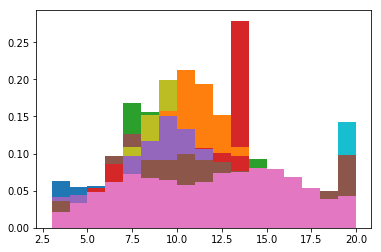

In [65]:
from datetime import datetime
import matplotlib.pyplot as plt

for key, tag, _, _ in models:
    start_hours = [7]
    end_hours = [15]
    apply_growth_rate = True
    max_day_diff = 3
    days_post_feeding = 1
    final_days_post_feeding = 1
    loss_factors = [0.16, 'expected_loss_factor'] # need to determine the right values here
    akpd_cutoffs = [0.01, 0.95]

    hour_filter_methods = ['manual', 'hour_hist', 'u-shape'] #  'u-shape',

    cohort_name_col = []
    akpd_cutoff_col = []
    hour_filter_method_col = []
    start_hour_col = []
    end_hour_col = []
    loss_factor_col = []
    starvation_days_col = []
    avg_weight_col = []
    avg_weight_error_col = []
    gt_avg_weight_col = []
    count_distribution_error_col = []
    camera_col = []
    weights_col = []

    for loss_factor in loss_factors:
        avg_weight_error_col.append([])
        avg_weight_error_col.append([])
        count_distribution_error_col.append([])

    for cohort_name in sorted(list(dfs.keys())):
        print(cohort_name)
        
        gt_metadata = gt_metadatas[cohort_name]

        last_feeding_date = gt_metadata['last_feeding_date']
        slaughter_date = gt_metadata['slaughter_date']

        if slaughter_date is not None and last_feeding_date is not None:
            date_diff = datetime.strptime(slaughter_date, '%Y-%m-%d') - datetime.strptime(last_feeding_date, '%Y-%m-%d')
            starvation_days = date_diff.days
        else:
            starvation_days = None

        df = dfs[cohort_name]
        df['estimated_weight_g'] = df[key]
        final_date_post_feeding = add_days(gt_metadata['last_feeding_date'], final_days_post_feeding)
        tdf = df[df.date <= final_date_post_feeding]

        start_end_hours = []

        for method in hour_filter_methods:
            if method == 'manual':
                for start_hour in start_hours:
                    for end_hour in end_hours:
                        start_end_hours.append((method, start_hour, end_hour))
            elif method == 'u-shape':
                df2 = df[(df.hour >= 3) & (df.hour <= 20)]

                #count, bins, _ = plt.hist(df2.hour, density = True, bins = (np.max(df2.hour) - np.min(df2.hour)))

                start_hour = np.min(df2.hour)
                end_hour = np.max(df2.hour)

                bins = np.arange(start_hour, end_hour + 1)

                weights = []

                for hour in np.arange(start_hour, end_hour + 1):
                    avg_weight = np.mean(df2[df2.hour == hour].estimated_weight_g)
                    weights.append(avg_weight)

                start_index = np.where(bins == 10)[0][0]

                lower_index = start_index
                upper_index = start_index

                is_iterating = True
                eps = 3

                while is_iterating:
                #     print(np.std(weights[lower_index:upper_index]))
                    if lower_index > 0 and upper_index < len(weights) - 1 and np.abs(weights[upper_index + 1] - weights[lower_index - 1]) < eps * np.std(weights[lower_index - 1:upper_index + 1]):
                        lower_index = lower_index - 1
                        upper_index = upper_index + 1
                    elif lower_index > 0 and np.abs(weights[upper_index] - weights[lower_index - 1]) < eps * np.std(weights[lower_index - 1:upper_index]):
                        lower_index = lower_index - 1
                    elif upper_index < len(weights) - 1 and np.abs(weights[upper_index + 1] - weights[lower_index]) < eps * np.std(weights[lower_index:upper_index + 1]):
                        upper_index = upper_index + 1
                    else:
                        is_iterating = False

                start_hour, end_hour = bins[lower_index], bins[upper_index]
                
                start_end_hours.append((method, start_hour, end_hour))
            elif method == 'hour_hist':
                df2 = df[(df.hour >= 3) & (df.hour <= 20)]

                count, bins, _ = plt.hist(df2.hour, density = True, bins = (np.max(df2.hour) - np.min(df2.hour)))

                idx_values = np.where(count > 1.0 / 18)[0]

                start_index = np.where(bins == 10)[0][0]
                start_array = np.where(idx_values == start_index)[0][0]

                lower_index = start_array
                upper_index = start_array

                while lower_index > 0 and (idx_values[lower_index] - idx_values[lower_index - 1] == 1):
                    lower_index = lower_index - 1
                while upper_index < len(idx_values) - 1 and (idx_values[upper_index + 1] - idx_values[upper_index] == 1):
                    upper_index = upper_index + 1

                start_hour, end_hour = bins[idx_values[lower_index]], bins[idx_values[upper_index]]

                start_end_hours.append((method, start_hour, end_hour))

        for akpd_cutoff in akpd_cutoffs:
            for method, start_hour, end_hour in start_end_hours:
                sampling_filter = SamplingFilter(
                    start_hour=start_hour,
                    end_hour=end_hour,
                    kf_cutoff=0.0
                )
                
                atdf = tdf[tdf.akpd_score >= akpd_cutoff]

                pm_base = gen_pm_base(atdf, sampling_filter)

                try:
                    weights = generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding)
                except ValidationError as err:
                    continue

                akpd_cutoff_col.append(akpd_cutoff)
                cohort_name_col.append(cohort_name)
                hour_filter_method_col.append(method)
                start_hour_col.append(start_hour)
                end_hour_col.append(end_hour)
                loss_factor_col.append(gt_metadata['expected_loss_factor'])
                starvation_days_col.append(starvation_days)
                avg_weight_col.append(np.mean(weights))
                gt_avg_weight_col.append(gt_metadata['gutted_average_weight'])
                camera_col.append(camera_type[cohort_name])
                weights_col.append(weights)

                for index, loss_factor in enumerate(loss_factors):
                    if loss_factor == 'expected_loss_factor':
                        loss_factor = gt_metadata['expected_loss_factor'] or 0.165

                        if loss_factor > 10:
                            loss_factor = loss_factor / 100.0

                    avg_weight_err, gutted_weight_prediction = generate_average_weight_accuracy(weights, gt_metadata, loss_factor)
                    avg_weight_error_col[index].append(avg_weight_err)

                    count_distribution_errors = generate_distribution_accuracy(weights, gt_metadata, loss_factor)
                    count_distribution_error_col[index].append(count_distribution_errors)
                    
    columns = {
        'cohort_name': cohort_name_col,
        'hour_filter_method_col': hour_filter_method_col,
        'akpd_cutoff_col': akpd_cutoff_col,
        'start_hour_col': start_hour_col,
        'end_hour_col': end_hour_col,
        'loss_factor_col': loss_factor_col,
        'starvation_days_col': starvation_days_col,
        'avg_weight_col': avg_weight_col,
        'gt_avg_weight_col': gt_avg_weight_col,
        'camera_col': camera_col,
        'weights_col': weights_col
    }

    for index, loss_factor in enumerate(loss_factors):
        if loss_factor == 'expected_loss_factor':
            col_name = 'avg_weight_error_exp'
            col_abs_name = 'avg_weight_error_abs_exp'
            col_abs_dist_name = 'avg_count_dist_error_abs_exp'
        else:
            col_name = 'avg_weight_error_%0.2f' % (loss_factor,)
            col_abs_name = 'avg_weight_error_abs_%0.2f' % (loss_factor,)
            col_abs_dist_name = 'avg_count_dist_error_abs_%0.2f' % (loss_factor,)

        columns[col_name] = avg_weight_error_col[index]
        columns[col_abs_name] = np.abs(avg_weight_error_col[index])
        columns[col_abs_dist_name] = [np.mean(np.abs(l)) for l in count_distribution_error_col[index]]

    tdf = pd.DataFrame(columns)
    
    df1 = tdf[(tdf.akpd_cutoff_col == 0.01) & (tdf.hour_filter_method_col == 'manual')][['cohort_name', 'avg_weight_col', 'gt_avg_weight_col', 'avg_weight_error_0.16', 'avg_weight_error_exp', 'loss_factor_col', 'weights_col']]
    df2 = tdf[(tdf.akpd_cutoff_col == 0.01) & (tdf.hour_filter_method_col == 'hour_hist')][['cohort_name', 'avg_weight_col', 'gt_avg_weight_col', 'avg_weight_error_0.16', 'avg_weight_error_exp','loss_factor_col', 'weights_col']]
    df3 = tdf[(tdf.akpd_cutoff_col == 0.01) & (tdf.hour_filter_method_col == 'u-shape')][['cohort_name', 'avg_weight_col', 'gt_avg_weight_col', 'avg_weight_error_0.16', 'avg_weight_error_exp', 'loss_factor_col', 'weights_col']]
    df4 = tdf[(tdf.akpd_cutoff_col == 0.95) & (tdf.hour_filter_method_col == 'manual')][['cohort_name', 'avg_weight_col', 'gt_avg_weight_col', 'avg_weight_error_0.16', 'avg_weight_error_exp', 'loss_factor_col', 'weights_col']]
    df5 = tdf[(tdf.akpd_cutoff_col == 0.95) & (tdf.hour_filter_method_col == 'hour_hist')][['cohort_name', 'avg_weight_col', 'gt_avg_weight_col', 'avg_weight_error_0.16', 'avg_weight_error_exp', 'loss_factor_col', 'weights_col']]
    df6 = tdf[(tdf.akpd_cutoff_col == 0.95) & (tdf.hour_filter_method_col == 'u-shape')][['cohort_name', 'avg_weight_col', 'gt_avg_weight_col', 'avg_weight_error_0.16', 'avg_weight_error_exp', 'loss_factor_col', 'weights_col']]
    
    all_dfs1.append(df1)
    all_dfs2.append(df2)
    all_dfs3.append(df3)
    all_dfs4.append(df4)
    all_dfs5.append(df5)
    all_dfs6.append(df6)

0 curr-synthetic


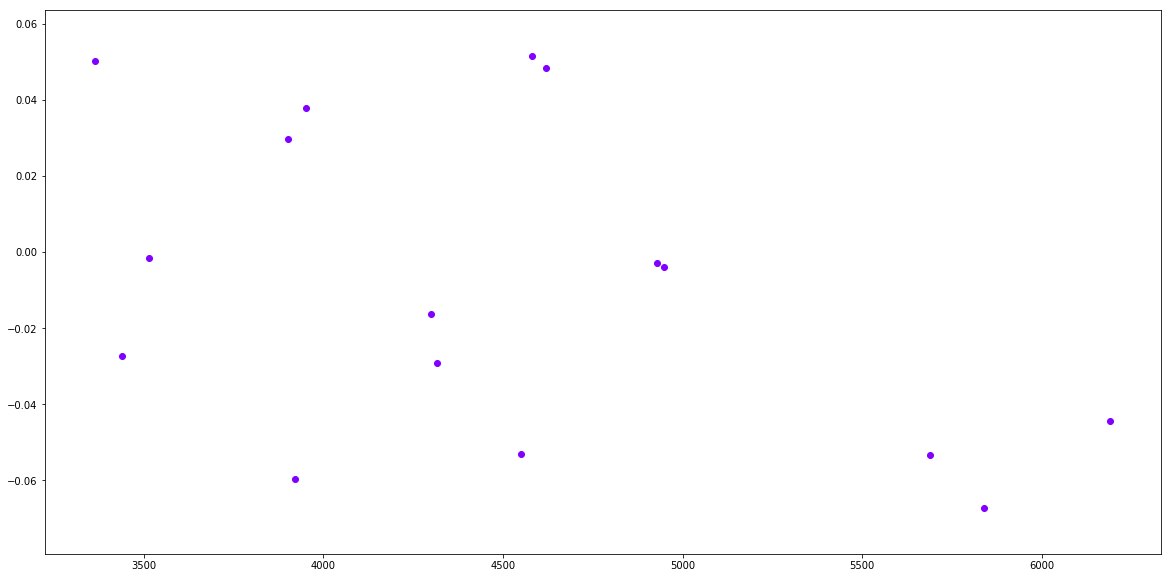

In [54]:
from matplotlib.pyplot import cm

plt.figure(figsize=(20, 10))

color=iter(cm.rainbow(np.linspace(0,1,len(models))))

all_dfs = all_dfs5

avg_under = {}

for index, model in enumerate(models):
    c = next(color)
    _, tag, _, _ = model
    print(index, tag)
    plt.scatter(all_dfs[index].gt_avg_weight_col, all_dfs[index]['avg_weight_error_0.16'], color = c, label=tag)

#     mask = all_dfs[index].gt_avg_weight_col > 5000
                   
#     avg_under[model[1]] = np.mean(all_dfs[index]['avg_weight_error_exp'][mask])
    
# plt.legend()

In [69]:
loss_factor_col = all_dfs5[2]['loss_factor_col']

lf = []

for loss_factor in loss_factor_col:
    if loss_factor > 1:
        lf.append(loss_factor / 100.0)
    elif loss_factor > 0:
        lf.append(loss_factor)
    else:
        lf.append(.165)
    
all_dfs5[2]['loss_factor_col'] = lf

In [85]:
mydf

,cohort_name,avg_weight_col,gt_avg_weight_col,avg_weight_error_0.16,avg_weight_error_exp,loss_factor_col,weights_col
4,aplavika_pen_id_95_2020-07-10_2020-07-26,5868.313540,4949,-0.003964,-0.021750,0.175,"[7594.762554272837, 4715.54620186972, 5128.858..."
10,bolaks_pen_id_88_2020-02-28_2020-03-10,5733.129816,4580,0.051491,0.045232,0.165,"[4957.910444058417, 5866.555557276809, 4849.57..."
16,dale_pen_id_143_2020-10-07_2020-10-21,3982.900277,3440,-0.027431,0.007303,0.130,"[6438.005566596985, 4228.494763374329, 4194.42..."
22,djubawik_pen_id_153_2020-11-10_2020-11-26,6411.571723,5690,-0.053476,-0.053476,0.160,"[6042.836982188687, 7273.471844590007, 7806.86..."
28,eldviktaren_pen_id_164_2020-09-21_2020-10-08,4206.858542,3365,0.050152,0.050152,0.160,"[4494.760943681249, 3933.9419587932207, 4814.4..."
34,langoy_pen_id_108_2020-05-07_2020-05-17,5766.116683,4620,0.048385,0.042144,0.165,"[5600.684285163879, 5329.577326774597, 4343.03..."
40,leivsethamran_pen_id_165_2020-10-18_2020-11-13,7041.428136,6190,-0.044459,-0.050147,0.165,"[10066.771507263184, 7475.998401641846, 7819.9..."
46,movikodden_pen_id_114_2020-11-03_2020-11-25,4388.809870,3920,-0.059541,-0.065139,0.165,"[4253.674499509063, 4124.0462045413915, 4585.4..."
52,movikodden_pen_id_167_2020-10-13_2020-10-30,5034.920076,4300,-0.016434,-0.039852,0.180,"[1685.7267298852166, 4715.050518258102, 5615.1..."
58,seglberget_pen_id_66_2020-05-13_2020-06-13,4879.655157,3950,0.037699,0.031522,0.165,"[5555.09090423584, 2793.7769889831543, 5214.95..."


In [108]:
for i in range(10):
    print(np.random.normal(np.random.normal(0, 1000), 500))

402.45535429997756
-295.5476439485182
-442.48498264201044
661.7692346508626
1527.9489962650441
3.421464558898947
-2040.8938044574825
1729.0891487945148
-355.70919489962523
42.00817929141198


In [247]:
mydf = all_dfs5[2]

counts = np.arange(100, 1100, 100)
offset_pcts = np.arange(0.01, 0.11, 0.01)

errors = np.zeros((len(counts), len(offset_pcts)))

harvest = mydf.iloc[0]

gt_weight = np.mean(harvest['weights_col'])

for count_i, count in enumerate(counts):
    for offset_i, offset_pct in enumerate(offset_pcts):
        offset = gt_weight * offset_pct
        
        results = []
        
        for i in np.arange(5000):
            weights = (np.mean(np.random.choice(harvest['weights_col'], count)) + offset)

            results.append(np.abs((weights - gt_weight) / gt_weight))

        errors[count_i, offset_i] = np.mean(results)

In [250]:
offset_pcts

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

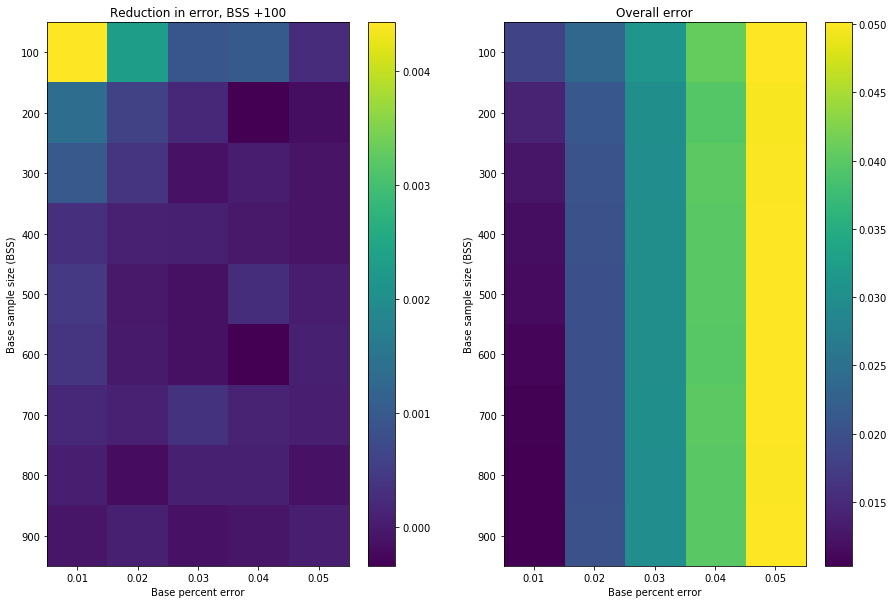

In [276]:
# plt.scatter(errors, np.abs(mydf['avg_weight_error_exp']))

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

im1 = ax[0].imshow(errors[0:-1,0:5] - errors[1:,0:5], interpolation='nearest')

ax[0].set_xticklabels(np.arange(0, 0.1, 0.01))
ax[0].set_yticklabels(np.arange(0, 1000, 100))
ax[0].set_xlabel('Base percent error')
ax[0].set_ylabel('Base sample size (BSS)')
ax[0].set_title('Reduction in error, BSS +100')

im2 = ax[1].imshow(errors[0:-1,0:5], interpolation='nearest')

ax[1].set_xticklabels(np.arange(0, 0.1, 0.01))
ax[1].set_yticklabels(np.arange(0, 1000, 100))
ax[1].set_xlabel('Base percent error')
ax[1].set_ylabel('Base sample size (BSS)')
ax[1].set_title('Overall error')

fig.colorbar(im1, ax = ax[0])
fig.colorbar(im2, ax = ax[1])

In [225]:
mydf = all_dfs5[2]

counts = np.arange(100, 2000, 25)

output2 = np.zeros((len(mydf), len(counts)))

idx = 0

for index, harvest in mydf.iterrows():
    gt_weight = np.mean(harvest['weights_col']) #* (1 - harvest['loss_factor_col']) #5000#harvest['gt_avg_weight_col']
    
    offset = gt_weight - np.mean(harvest['weights_col'])# * (1 - harvest['loss_factor_col'])
    #500# np.random.uniform(-1000, 1000)
    print(offset, idx, len(mydf))

    errors = []

    for count in counts:
        results = []

        for i in np.arange(500):
            weights = (np.mean(np.random.choice(harvest['weights_col'], count)) + offset)# * (1 - harvest['loss_factor_col'])

            results.append(np.abs((weights - gt_weight) / gt_weight))

        errors.append(np.mean(results))
        
    output2[idx,:] = errors
    
    idx = idx + 1

0.0 0 16
0.0 1 16
0.0 2 16
0.0 3 16
0.0 4 16
0.0 5 16
0.0 6 16
0.0 7 16
0.0 8 16
0.0 9 16
0.0 10 16
0.0 11 16
0.0 12 16
0.0 13 16
0.0 14 16
0.0 15 16


In [78]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

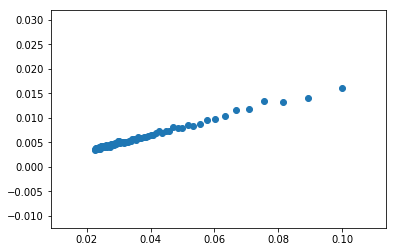

In [213]:
plt.scatter((1 / np.sqrt(counts)), output2[0,:])

1.240551268227034 -0.02175011711887755
1.2488919011020967 0.04523218256050854
1.2423904985050067 0.007303267721339035
1.2598058498876106 -0.053476230744776865
1.2466072227132172 0.050151909508267326
1.2501149392137536 0.04214446535280268
1.2303246749668566 -0.050146608508470185
1.2639089506937895 -0.06513871398836282
1.2991829594644135 -0.03985245056038197
1.2024262943832689 0.03152203948868306
1.2976083047770455 -0.06729264103289427
1.2268455348287466 0.02352349010274513
1.283281135979904 -0.02905365959255118
1.2262448334846574 -0.002922623659746997
1.2383379695455021 -0.05319940636346143
1.2788405465401884 -0.007444854807640676


Text(0.5, 1.0, 'LLN: Correlation vs Harvest Report Error: -28% correlation')

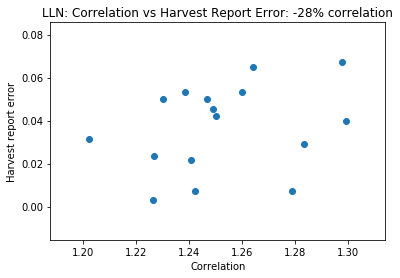

In [216]:
from sklearn.linear_model import LinearRegression

indicators = []

idx = 0
for index, harvest in mydf.iterrows():
    X = (1 / np.sqrt(counts)).reshape(-1,1)
    y = output2[idx,:]
#     y = (1 / np.sqrt(counts))
#     X = output2[idx,:].reshape(-1,1)
    
    reg = LinearRegression(fit_intercept=True).fit(X, y)
#     indicator = reg.intercept_
    indicator = errors[idx] / reg.coef_[0]
#     / errors[idx]
#     indicator = reg.score(X, y)
#     indicator = np.corrcoef(output2[idx,:], 1 / np.sqrt(counts))  [0, 1]
#     indicator = output2[idx,-1]
    indicators.append(indicator)
    
    
    
    print(indicator, harvest['avg_weight_error_exp'])
    idx = idx + 1
    
plt.scatter(indicators, np.abs(mydf['avg_weight_error_exp']))

overall_corr = np.corrcoef(indicators, np.abs(mydf['avg_weight_error_exp']))[0, 1]

plt.xlabel('Correlation')
plt.ylabel('Harvest report error')
plt.title('LLN: Correlation vs Harvest Report Error: %0.0f%% correlation' % (overall_corr * -100, ))

0.43831510069023133 -0.02175011711887755
0.1488505489690316 0.04523218256050854
0.9941941664171524 0.007303267721339035
0.027352899302241163 -0.053476230744776865
0.002701439082679391 0.050151909508267326
0.19816013733150117 0.04214446535280268
0.01657104083135763 -0.050146608508470185
0.007242434072071813 -0.06513871398836282
0.010547262738778485 -0.03985245056038197
0.3882389261729883 0.03152203948868306
0.002774041987224418 -0.06729264103289427
0.8135191181020227 0.02352349010274513
0.3017508258011361 -0.02905365959255118
0.996370111784527 -0.002922623659746997
0.02399882490466143 -0.05319940636346143
0.9742904945966193 -0.007444854807640676


Text(0.5, 1.0, 'LLN: Correlation vs Harvest Report Error: 93% correlation')

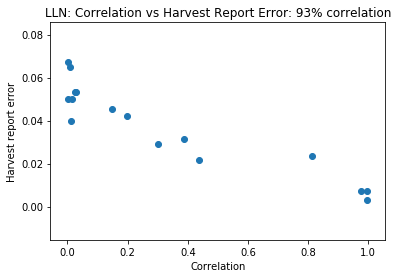

In [102]:
from sklearn.linear_model import LinearRegression

indicators = []

idx = 0
for index, harvest in mydf.iterrows():
    X = (1 / np.sqrt(counts)).reshape(-1,1)
    y = output[idx,:]
    
    reg = LinearRegression(fit_intercept=True).fit(X, y)
    indicator = reg.score(X, y)
#     indicator = np.corrcoef(output[idx,:], 1 / np.sqrt(counts))  [0, 1]
    indicators.append(indicator)
    
    
    
    print(indicator, harvest['avg_weight_error_exp'])
    idx = idx + 1
    
plt.scatter(indicators, np.abs(mydf['avg_weight_error_exp']))

overall_corr = np.corrcoef(indicators, np.abs(mydf['avg_weight_error_exp']))[0, 1]

plt.xlabel('Correlation')
plt.ylabel('Harvest report error')
plt.title('LLN: Correlation vs Harvest Report Error: %0.0f%% correlation' % (overall_corr * -100, ))

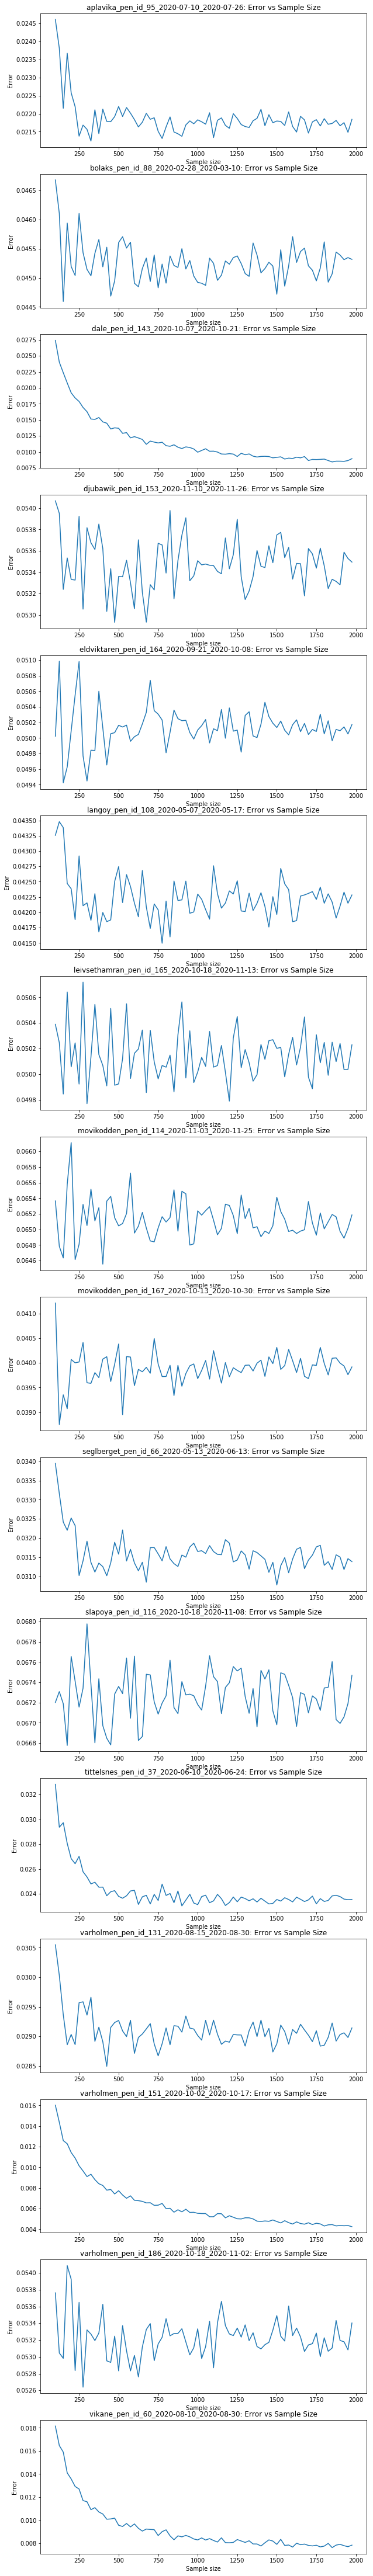

In [79]:
fig, axes = plt.subplots(len(mydf), 1, figsize=(10, 5 * len(mydf)))

idx = 0

for index, harvest in mydf.iterrows():
    axes[idx].plot(counts, output[idx, ])
    axes[idx].set_xlabel('Sample size')
    axes[idx].set_ylabel('Error')
    axes[idx].set_title('%s: Error vs Sample Size' % (harvest['cohort_name'], ))
    
    idx = idx + 1

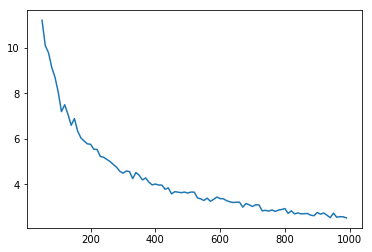

In [136]:
n_values = np.arange(50, 1000, 10)

samples = np.random.normal(500, 100, 10000)

avgs = []

for n_value in n_values:
    local_avgs = []
    
    for i in range(1000):
        local_avgs.append(np.mean(np.random.choice(samples, n_value)))
        
    avgs.append(np.mean(np.abs(np.array(local_avgs) - 500)))
    
plt.plot(n_values, avgs)

In [149]:
output2[:,5]

array([0.01084551, 0.01483291, 0.01789395, 0.0125224 , 0.0132764 ,
       0.01537691, 0.0125634 , 0.01524547, 0.01370418, 0.01390651,
       0.01424087, 0.0168639 , 0.01076427, 0.01044724, 0.01255506,
       0.0114505 ])

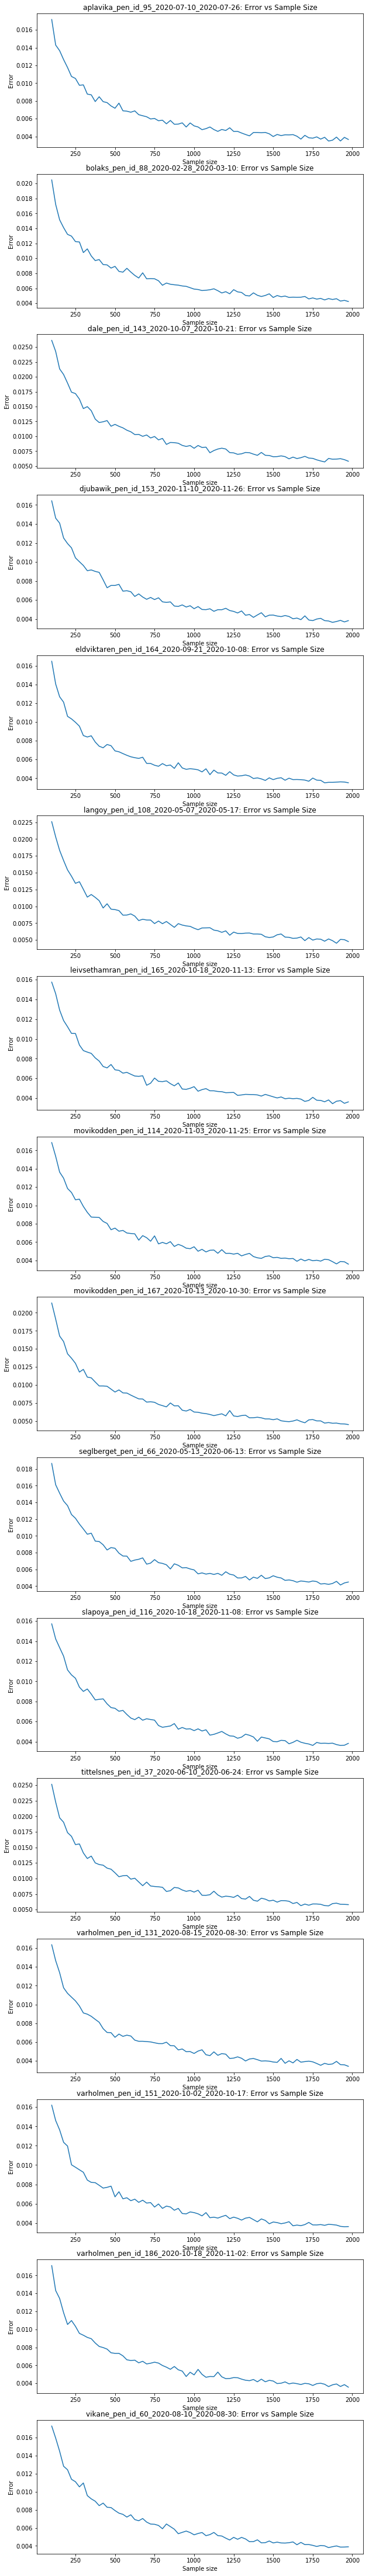

In [169]:
fig, axes = plt.subplots(len(mydf), 1, figsize=(10, 5 * len(mydf)))

idx = 0

for index, harvest in mydf.iterrows():
    axes[idx].plot(counts, output2[idx, ])
    axes[idx].set_xlabel('Sample size')
    axes[idx].set_ylabel('Error')
    axes[idx].set_title('%s: Error vs Sample Size' % (harvest['cohort_name'], ))
    
    idx = idx + 1

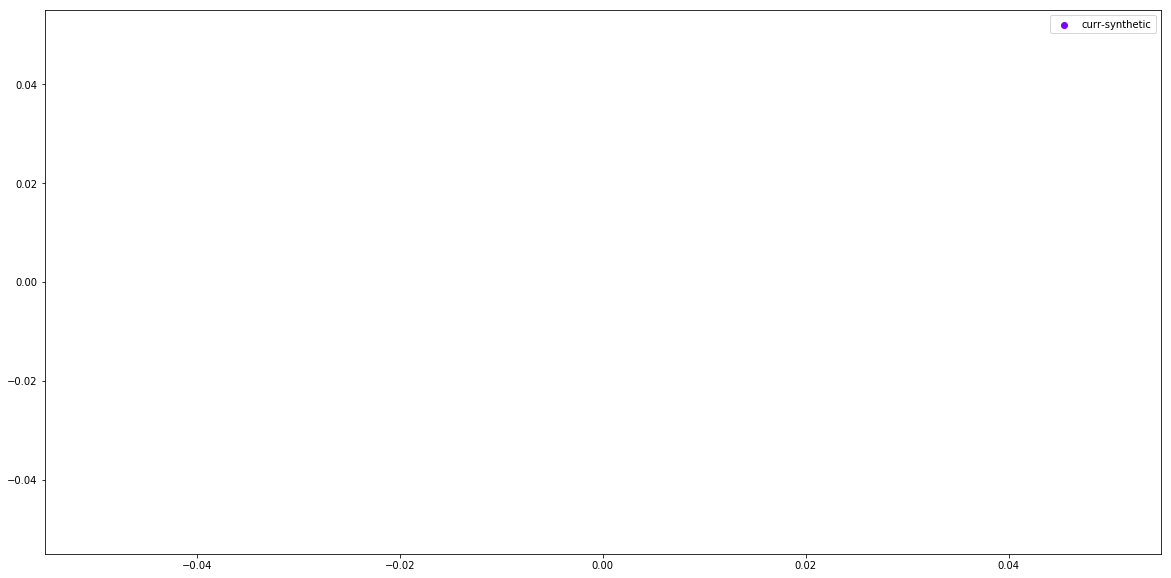

In [32]:
plt.figure(figsize=(20, 10))

my_models = ['curr-synthetic']

color=iter(cm.rainbow(np.linspace(0,1,len(my_models))))

for index, model in enumerate(models):
    _, tag, _, _ = model
    
    if tag not in my_models: # 'augV1-ols-akpd-halfinfl',
        continue
    c = next(color)
    plt.scatter(all_dfs[index].gt_avg_weight_col, all_dfs2[index]['avg_weight_error_exp'], color = c, label=tag)
    
plt.legend()



In [ ]:
plt.figure(figsize=(20, 10))

my_models = ['curr-synthetic', 'augV1-ols', 'jitter-ols'] # , 'augV4-o-a-h-99', 'augV4-o-a-h-99#2'

color=iter(cm.rainbow(np.linspace(0,1,len(my_models))))

for index, model in enumerate(models):
    _, tag, _, _ = model
    
    if tag not in my_models: # 'augV1-ols-akpd-halfinfl',
        continue
    c = next(color)
    plt.scatter(all_dfs[index].gt_avg_weight_col, all_dfs5[index]['avg_weight_error_exp'], color = c, label=tag)
    
plt.legend()



In [ ]:
all_dfs = all_dfs21

metric = []

for index, model in enumerate(models):
    _, tag, _, _ = model
    print('%-*s: %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f' % (25, tag, 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 90), 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 50), np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)), 100 * np.mean((all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_exp'])), 100 * np.std((all_dfs[index]['avg_weight_error_0.16']))))
    metric.append(np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)))
    
print(np.mean(metric))

In [17]:
all_dfs = all_dfs1

metric = []

for index, model in enumerate(models):
    _, tag, _, _ = model
    print('%-*s: %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f' % (25, tag, 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 90), 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 50), np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)), 100 * np.mean((all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_exp'])), 100 * np.std((all_dfs[index]['avg_weight_error_0.16']))))
    metric.append(np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)))
    
print(np.mean(metric))

IndexError: cannot do a non-empty take from an empty axes.

In [ ]:
all_dfs = all_dfs2

metric = []

for index, model in enumerate(models):
    _, tag, _, _ = model
    print('%-*s: %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f' % (25, tag, 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 90), 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 50), np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)), 100 * np.mean((all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_exp'])), 100 * np.std((all_dfs[index]['avg_weight_error_0.16']))))
    metric.append(np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)))
    
print(np.mean(metric))

In [ ]:
all_dfs = all_dfs3

metric = []

for index, model in enumerate(models):
    _, tag, _, _ = model
    print('%-*s: %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f' % (25, tag, 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 90), 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 50), np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)), 100 * np.mean((all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_exp'])), 100 * np.std((all_dfs[index]['avg_weight_error_0.16']))))
    metric.append(np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)))
    
print(np.mean(metric))

In [ ]:
all_dfs = all_dfs4

metric = []

for index, model in enumerate(models):
    _, tag, _, _ = model
    print('%-*s: %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f' % (25, tag, 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 90), 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 50), np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)), 100 * np.mean((all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_exp'])), 100 * np.std((all_dfs[index]['avg_weight_error_0.16']))))
    metric.append(np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)))
    
print(np.mean(metric))

In [ ]:
all_dfs = all_dfs5

metric = []

for index, model in enumerate(models):
    _, tag, _, _ = model
    print('%-*s: %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f' % (25, tag, 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 90), 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 50), np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)), 100 * np.mean((all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_exp'])), 100 * np.std((all_dfs[index]['avg_weight_error_0.16']))))
    metric.append(np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)))
    
print(np.mean(metric))

In [ ]:
all_dfs = all_dfs6

metric = []

for index, model in enumerate(models):
    _, tag, _, _ = model
    print('%-*s: %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f' % (25, tag, 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 90), 100 * np.percentile(np.abs(all_dfs[index]['avg_weight_error_exp']), 50), np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)), 100 * np.mean((all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_0.16'])), 100 * np.mean(np.abs(all_dfs[index]['avg_weight_error_exp'])), 100 * np.std((all_dfs[index]['avg_weight_error_0.16']))))
    metric.append(np.sqrt(np.mean((50 * np.abs(all_dfs[index]['avg_weight_error_exp'])) ** 2)))
    
print(np.mean(metric))

In [ ]:
print(models[0])
all_dfs[4]

# dfs['aplavika_pen_id_95_2020-07-10_2020-07-26'].iloc[0]

In [ ]:
print(models[1])
all_dfs[1]

In [ ]:
# # print(np.mean(np.abs(df4['avg_weight_error_0.16'])), np.mean(np.abs(df3['avg_weight_error_0.16'])), np.mean(np.abs(df5['avg_weight_error_0.16'])), np.mean(np.abs(df1['avg_weight_error_0.16'])), np.mean(np.abs(df6['avg_weight_error_0.16'])), np.mean(np.abs(df7['avg_weight_error_0.16'])))
# # print(np.std((df4['avg_weight_error_0.16'])), np.std((df3['avg_weight_error_0.16'])), np.std((df5['avg_weight_error_0.16'])), np.std((df1['avg_weight_error_0.16'])), np.std((df6['avg_weight_error_0.16'])), np.std((df7['avg_weight_error_0.16'])))

# print(np.mean(np.abs(df5['avg_weight_error_0.16'])), np.mean(np.abs(df1['avg_weight_error_0.16'])), np.mean(np.abs(df6['avg_weight_error_0.16'])), np.mean(np.abs(df7['avg_weight_error_0.16'])), np.mean(np.abs(df8['avg_weight_error_0.16'])))
# print(np.std((df5['avg_weight_error_0.16'])), np.std((df1['avg_weight_error_0.16'])), np.std((df6['avg_weight_error_0.16'])), np.std((df7['avg_weight_error_0.16'])), np.std((df8['avg_weight_error_0.16'])))


In [ ]:
# # print(np.mean(np.abs(df4['avg_weight_error_exp'])), np.mean(np.abs(df3['avg_weight_error_exp'])), np.mean(np.abs(df5['avg_weight_error_exp'])), np.mean(np.abs(df1['avg_weight_error_exp'])), np.mean(np.abs(df6['avg_weight_error_exp'])), np.mean(np.abs(df7['avg_weight_error_exp'])))
# # print(np.std((df4['avg_weight_error_exp'])), np.std((df3['avg_weight_error_exp'])), np.std((df5['avg_weight_error_exp'])), np.std((df1['avg_weight_error_exp'])), np.std((df6['avg_weight_error_exp'])), np.std((df7['avg_weight_error_exp'])))

# print(np.mean(np.abs(df5['avg_weight_error_exp'])), np.mean(np.abs(df1['avg_weight_error_exp'])), np.mean(np.abs(df6['avg_weight_error_exp'])), np.mean(np.abs(df7['avg_weight_error_exp'])), np.mean(np.abs(df8['avg_weight_error_exp'])))
# print(np.std((df5['avg_weight_error_exp'])), np.std((df1['avg_weight_error_exp'])), np.std((df6['avg_weight_error_exp'])), np.std((df7['avg_weight_error_exp'])), np.std((df8['avg_weight_error_exp'])))



In [ ]:
# np.mean(tdf[tdf.akpd_cutoff_col == 0.01])
# np.std(tdf[(tdf.akpd_cutoff_col == 0.01) & (tdf.hour_filter_method_col == 'manual')])
# np.std(tdf[(tdf.akpd_cutoff_col == 0.01) & (tdf.hour_filter_method_col == 'hour_hist')])
# np.mean(tdf[tdf.akpd_cutoff_col == 0.95])
# np.std(tdf[tdf.akpd_cutoff_col == 0.95])

In [ ]:
import statsmodels.api as sm

tdf1 = tdf[tdf['starvation_days_col'] > 0]

plt.scatter(tdf1['starvation_days_col'], tdf1['avg_weight_error_0.14'])

X = tdf1['starvation_days_col']
X = sm.add_constant(X)
model = sm.OLS(tdf1['avg_weight_error_0.14'], X)
results = model.fit()
results.summary()

In [ ]:
plt.scatter(tdf['avg_weight_col'], tdf['avg_weight_error_0.14'])

X = tdf['avg_weight_col']
X = sm.add_constant(X)
model = sm.OLS(tdf['avg_weight_error_0.14'], X)
results = model.fit()
results.summary()

In [ ]:
np.mean(np.abs(tdf1['avg_weight_error_0.14'])), np.mean(np.abs(tdf1['avg_weight_error_0.14'] - 0.0292 + 0.0028 * tdf1['starvation_days_col']))

In [ ]:
plt.plot(tdf['avg_weight_error_0.14'], tdf['avg_weight_error_0.14'], color = 'blue')
plt.scatter(tdf['avg_weight_error_0.14'], tdf['avg_weight_error_0.16'], color = 'green')
plt.scatter(tdf['avg_weight_error_0.14'], tdf.avg_weight_error_exp, color = 'red')

In [ ]:
plt.hist(tdf.avg_weight_error_exp)
plt.hist(tdf['avg_weight_error_0.16'])

In [ ]:
tdf1 = tdf[tdf.hour_filter_method_col == 'manual']
mask1 = tdf1.akpd_cutoff_col == 0.95
counts, bins, _ = plt.hist(tdf1[mask1]['avg_weight_error_0.14'], alpha = 0.5, color = 'cyan')
plt.hist(tdf1[mask1]['avg_weight_error_exp'], alpha = 0.5, color = 'red', bins = bins)

<h1> Generate average weight accuracy with new model </h1>

In [ ]:
np.mean(tdf[tdf.akpd_cutoff_col == 0.01])
np.std(tdf[tdf.akpd_cutoff_col == 0.01])
np.mean(tdf[tdf.akpd_cutoff_col == 0.95])
np.std(tdf[tdf.akpd_cutoff_col == 0.95])
tdf[tdf.hour_filter_method_col == 'hour_hist']
tdf[tdf.hour_filter_method_col == 'manual']

In [ ]:
tdf1 = tdf[tdf.hour_filter_method_col == 'hour_hist']
mask1 = tdf1.akpd_cutoff_col == 0.01
counts, bins, _ = plt.hist(tdf1[mask1]['avg_weight_error_0.14'], alpha = 0.5, color = 'cyan')
plt.hist(tdf1[~mask1]['avg_weight_error_0.14'], alpha = 0.5, color = 'red', bins = bins)

In [ ]:
start_hours = [7]
end_hours = [15]
apply_growth_rate = True
max_day_diff = 3
days_post_feeding = 1
final_days_post_feeding = 1
loss_factors = [0.16, 'expected_loss_factor'] # need to determine the right values here
akpd_cutoffs = [0.01, 0.95]

hour_filter_methods = ['manual', 'hour_hist'] #  'u-shape',

cohort_name_col = []
akpd_cutoff_col = []
hour_filter_method_col = []
start_hour_col = []
end_hour_col = []
loss_factor_col = []
starvation_days_col = []
avg_weight_col = []
avg_weight_error_col = []
gt_avg_weight_col = []
count_distribution_error_col = []

for loss_factor in loss_factors:
    avg_weight_error_col.append([])
    count_distribution_error_col.append([])

for cohort_name in sorted(list(dfs.keys())):
    print(cohort_name)
# for cohort_name in ['dale_pen_id_143_2020-10-07_2020-10-21']:
    gt_metadata = gt_metadatas[cohort_name]
    
    last_feeding_date = gt_metadata['last_feeding_date']
    slaughter_date = gt_metadata['slaughter_date']

    if slaughter_date is not None and last_feeding_date is not None:
        date_diff = datetime.strptime(slaughter_date, '%Y-%m-%d') - datetime.strptime(last_feeding_date, '%Y-%m-%d')
        starvation_days = date_diff.days
    else:
        starvation_days = None
        
    df = dfs[cohort_name]
    
    mask = df['weight_v1'] > 0
    
    df['estimated_weight_g'][mask] = df['weight_v6'][mask]
    df['estimated_weight_g'][~mask] = df['weight_v1'][~mask]    
    
    final_date_post_feeding = add_days(gt_metadata['last_feeding_date'], final_days_post_feeding)
    tdf = df[df.date <= final_date_post_feeding]
    
    start_end_hours = []
    
    for method in hour_filter_methods:
        if method == 'manual':
            for start_hour in start_hours:
                for end_hour in end_hours:
                    start_end_hours.append((method, start_hour, end_hour))
        elif method == 'u-shape':
            pass
        elif method == 'hour_hist':
            df2 = df[(df.hour >= 3) & (df.hour <= 20)]

            count, bins, _ = plt.hist(df2.hour, density = True, bins = (np.max(df2.hour) - np.min(df2.hour)))

            idx_values = np.where(count > 1.0 / 18)[0]

            start_index = np.where(bins == 10)[0][0]
            start_array = np.where(idx_values == start_index)[0][0]

            lower_index = start_array
            upper_index = start_array

            while lower_index > 0 and (idx_values[lower_index] - idx_values[lower_index - 1] == 1):
                lower_index = lower_index - 1
            while upper_index < len(idx_values) - 1 and (idx_values[upper_index + 1] - idx_values[upper_index] == 1):
                upper_index = upper_index + 1
    
            start_hour, end_hour = bins[idx_values[lower_index]], bins[idx_values[upper_index]]
            
            start_end_hours.append((method, start_hour, end_hour))
    
    for akpd_cutoff in akpd_cutoffs:
        for method, start_hour, end_hour in start_end_hours:
            sampling_filter = SamplingFilter(
                start_hour=start_hour,
                end_hour=end_hour,
                kf_cutoff=0.0,
                akpd_score_cutoff=akpd_cutoff
            )

            pm_base = gen_pm_base(tdf, sampling_filter)

            try:
                weights = generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding)
            except ValidationError as err:
                continue

            akpd_cutoff_col.append(akpd_cutoff)
            cohort_name_col.append(cohort_name)
            hour_filter_method_col.append(method)
            start_hour_col.append(start_hour)
            end_hour_col.append(end_hour)
            loss_factor_col.append(gt_metadata['expected_loss_factor'])
            starvation_days_col.append(starvation_days)
            avg_weight_col.append(np.mean(weights))
            gt_avg_weight_col.append(gt_metadata['gutted_average_weight'])

            for index, loss_factor in enumerate(loss_factors):
                if loss_factor == 'expected_loss_factor':
                    loss_factor = gt_metadata['expected_loss_factor'] or 0.165
                    
                    if loss_factor > 10:
                        loss_factor = loss_factor / 100.0
                    
                avg_weight_err = generate_average_weight_accuracy(weights, gt_metadata, loss_factor)
                avg_weight_error_col[index].append(avg_weight_err)

                count_distribution_errors = generate_distribution_accuracy(weights, gt_metadata, loss_factor)
                count_distribution_error_col[index].append(count_distribution_errors)


In [ ]:
columns = {
    'cohort_name': cohort_name_col,
    'hour_filter_method_col': hour_filter_method_col,
    'akpd_cutoff_col': akpd_cutoff_col,
    'start_hour_col': start_hour_col,
    'end_hour_col': end_hour_col,
    'loss_factor_col': loss_factor_col,
    'starvation_days_col': starvation_days_col,
    'avg_weight_col': avg_weight_col,
    'gt_avg_weight_col': gt_avg_weight_col
}

for index, loss_factor in enumerate(loss_factors):
    if loss_factor == 'expected_loss_factor':
        col_name = 'avg_weight_error_exp'
        col_abs_name = 'avg_weight_error_abs_exp'
        col_abs_dist_name = 'avg_count_dist_error_abs_exp'
    else:
        col_name = 'avg_weight_error_%0.2f' % (loss_factor,)
        col_abs_name = 'avg_weight_error_abs_%0.2f' % (loss_factor,)
        col_abs_dist_name = 'avg_count_dist_error_abs_%0.2f' % (loss_factor,)
        
    columns[col_name] = avg_weight_error_col[index]
    columns[col_abs_name] = np.abs(avg_weight_error_col[index])
    columns[col_abs_dist_name] = [np.mean(np.abs(l)) for l in count_distribution_error_col[index]]

tdf = pd.DataFrame(columns)

In [ ]:
df6 = tdf[(tdf.akpd_cutoff_col == 0.01) & (tdf.hour_filter_method_col == 'hour_hist')][['cohort_name', 'gt_avg_weight_col', 'avg_weight_error_0.16', 'avg_weight_error_exp']]


In [ ]:
start_hours = [7]
end_hours = [15]
apply_growth_rate = True
max_day_diff = 3
days_post_feeding = 1
final_days_post_feeding = 1
loss_factors = [0.16, 'expected_loss_factor'] # need to determine the right values here
akpd_cutoffs = [0.01, 0.95]

hour_filter_methods = ['manual', 'hour_hist'] #  'u-shape',

cohort_name_col = []
akpd_cutoff_col = []
hour_filter_method_col = []
start_hour_col = []
end_hour_col = []
loss_factor_col = []
starvation_days_col = []
avg_weight_col = []
avg_weight_error_col = []
gt_avg_weight_col = []
count_distribution_error_col = []

for loss_factor in loss_factors:
    avg_weight_error_col.append([])
    count_distribution_error_col.append([])

for cohort_name in sorted(list(dfs.keys())):
    print(cohort_name)
# for cohort_name in ['dale_pen_id_143_2020-10-07_2020-10-21']:
    gt_metadata = gt_metadatas[cohort_name]
    
    last_feeding_date = gt_metadata['last_feeding_date']
    slaughter_date = gt_metadata['slaughter_date']

    if slaughter_date is not None and last_feeding_date is not None:
        date_diff = datetime.strptime(slaughter_date, '%Y-%m-%d') - datetime.strptime(last_feeding_date, '%Y-%m-%d')
        starvation_days = date_diff.days
    else:
        starvation_days = None
        
    df = dfs[cohort_name]
    
    mask = df['weight_v5'] > 8000
    
    df['estimated_weight_g'][mask] = df['weight_v7'][mask]
    df['estimated_weight_g'][~mask] = df['weight_v5'][~mask]    
    
    final_date_post_feeding = add_days(gt_metadata['last_feeding_date'], final_days_post_feeding)
    tdf = df[df.date <= final_date_post_feeding]
    
    start_end_hours = []
    
    for method in hour_filter_methods:
        if method == 'manual':
            for start_hour in start_hours:
                for end_hour in end_hours:
                    start_end_hours.append((method, start_hour, end_hour))
        elif method == 'u-shape':
            pass
        elif method == 'hour_hist':
            df2 = df[(df.hour >= 3) & (df.hour <= 20)]

            count, bins, _ = plt.hist(df2.hour, density = True, bins = (np.max(df2.hour) - np.min(df2.hour)))

            idx_values = np.where(count > 1.0 / 18)[0]

            start_index = np.where(bins == 10)[0][0]
            start_array = np.where(idx_values == start_index)[0][0]

            lower_index = start_array
            upper_index = start_array

            while lower_index > 0 and (idx_values[lower_index] - idx_values[lower_index - 1] == 1):
                lower_index = lower_index - 1
            while upper_index < len(idx_values) - 1 and (idx_values[upper_index + 1] - idx_values[upper_index] == 1):
                upper_index = upper_index + 1
    
            start_hour, end_hour = bins[idx_values[lower_index]], bins[idx_values[upper_index]]
            
            start_end_hours.append((method, start_hour, end_hour))
    
    for akpd_cutoff in akpd_cutoffs:
        for method, start_hour, end_hour in start_end_hours:
            sampling_filter = SamplingFilter(
                start_hour=start_hour,
                end_hour=end_hour,
                kf_cutoff=0.0,
                akpd_score_cutoff=akpd_cutoff
            )

            pm_base = gen_pm_base(tdf, sampling_filter)

            try:
                weights = generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding)
            except ValidationError as err:
                continue

            akpd_cutoff_col.append(akpd_cutoff)
            cohort_name_col.append(cohort_name)
            hour_filter_method_col.append(method)
            start_hour_col.append(start_hour)
            end_hour_col.append(end_hour)
            loss_factor_col.append(gt_metadata['expected_loss_factor'])
            starvation_days_col.append(starvation_days)
            avg_weight_col.append(np.mean(weights))
            gt_avg_weight_col.append(gt_metadata['gutted_average_weight'])

            for index, loss_factor in enumerate(loss_factors):
                if loss_factor == 'expected_loss_factor':
                    loss_factor = gt_metadata['expected_loss_factor'] or 0.165
                    
                    if loss_factor > 10:
                        loss_factor = loss_factor / 100.0
                    
                avg_weight_err = generate_average_weight_accuracy(weights, gt_metadata, loss_factor)
                avg_weight_error_col[index].append(avg_weight_err)

                count_distribution_errors = generate_distribution_accuracy(weights, gt_metadata, loss_factor)
                count_distribution_error_col[index].append(count_distribution_errors)


In [ ]:
columns = {
    'cohort_name': cohort_name_col,
    'hour_filter_method_col': hour_filter_method_col,
    'akpd_cutoff_col': akpd_cutoff_col,
    'start_hour_col': start_hour_col,
    'end_hour_col': end_hour_col,
    'loss_factor_col': loss_factor_col,
    'starvation_days_col': starvation_days_col,
    'avg_weight_col': avg_weight_col,
    'gt_avg_weight_col': gt_avg_weight_col
}

for index, loss_factor in enumerate(loss_factors):
    if loss_factor == 'expected_loss_factor':
        col_name = 'avg_weight_error_exp'
        col_abs_name = 'avg_weight_error_abs_exp'
        col_abs_dist_name = 'avg_count_dist_error_abs_exp'
    else:
        col_name = 'avg_weight_error_%0.2f' % (loss_factor,)
        col_abs_name = 'avg_weight_error_abs_%0.2f' % (loss_factor,)
        col_abs_dist_name = 'avg_count_dist_error_abs_%0.2f' % (loss_factor,)
        
    columns[col_name] = avg_weight_error_col[index]
    columns[col_abs_name] = np.abs(avg_weight_error_col[index])
    columns[col_abs_dist_name] = [np.mean(np.abs(l)) for l in count_distribution_error_col[index]]

tdf = pd.DataFrame(columns)

In [ ]:
df7 = tdf[(tdf.akpd_cutoff_col == 0.01) & (tdf.hour_filter_method_col == 'hour_hist')][['cohort_name', 'gt_avg_weight_col', 'avg_weight_error_0.16', 'avg_weight_error_exp']]


In [ ]:
start_hours = [7]
end_hours = [15]
apply_growth_rate = True
max_day_diff = 3
days_post_feeding = 1
final_days_post_feeding = 1
loss_factors = [0.16, 'expected_loss_factor'] # need to determine the right values here
akpd_cutoffs = [0.01, 0.95]

hour_filter_methods = ['manual', 'hour_hist'] #  'u-shape',

cohort_name_col = []
akpd_cutoff_col = []
hour_filter_method_col = []
start_hour_col = []
end_hour_col = []
loss_factor_col = []
starvation_days_col = []
avg_weight_col = []
avg_weight_error_col = []
gt_avg_weight_col = []
count_distribution_error_col = []

for loss_factor in loss_factors:
    avg_weight_error_col.append([])
    count_distribution_error_col.append([])

for cohort_name in sorted(list(dfs.keys())):
    print(cohort_name)
# for cohort_name in ['dale_pen_id_143_2020-10-07_2020-10-21']:
    gt_metadata = gt_metadatas[cohort_name]
    
    last_feeding_date = gt_metadata['last_feeding_date']
    slaughter_date = gt_metadata['slaughter_date']

    if slaughter_date is not None and last_feeding_date is not None:
        date_diff = datetime.strptime(slaughter_date, '%Y-%m-%d') - datetime.strptime(last_feeding_date, '%Y-%m-%d')
        starvation_days = date_diff.days
    else:
        starvation_days = None
        
    df = dfs[cohort_name]
    
    mask = df['weight_v5'] > 6000
    
    df['estimated_weight_g'][mask] = df['weight_v8'][mask]
    df['estimated_weight_g'][~mask] = df['weight_v5'][~mask]    
    
    final_date_post_feeding = add_days(gt_metadata['last_feeding_date'], final_days_post_feeding)
    tdf = df[df.date <= final_date_post_feeding]
    
    start_end_hours = []
    
    for method in hour_filter_methods:
        if method == 'manual':
            for start_hour in start_hours:
                for end_hour in end_hours:
                    start_end_hours.append((method, start_hour, end_hour))
        elif method == 'u-shape':
            pass
        elif method == 'hour_hist':
            df2 = df[(df.hour >= 3) & (df.hour <= 20)]

            count, bins, _ = plt.hist(df2.hour, density = True, bins = (np.max(df2.hour) - np.min(df2.hour)))

            idx_values = np.where(count > 1.0 / 18)[0]

            start_index = np.where(bins == 10)[0][0]
            start_array = np.where(idx_values == start_index)[0][0]

            lower_index = start_array
            upper_index = start_array

            while lower_index > 0 and (idx_values[lower_index] - idx_values[lower_index - 1] == 1):
                lower_index = lower_index - 1
            while upper_index < len(idx_values) - 1 and (idx_values[upper_index + 1] - idx_values[upper_index] == 1):
                upper_index = upper_index + 1
    
            start_hour, end_hour = bins[idx_values[lower_index]], bins[idx_values[upper_index]]
            
            start_end_hours.append((method, start_hour, end_hour))
    
    for akpd_cutoff in akpd_cutoffs:
        for method, start_hour, end_hour in start_end_hours:
            sampling_filter = SamplingFilter(
                start_hour=start_hour,
                end_hour=end_hour,
                kf_cutoff=0.0,
                akpd_score_cutoff=akpd_cutoff
            )

            pm_base = gen_pm_base(tdf, sampling_filter)

            try:
                weights = generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding)
            except ValidationError as err:
                continue

            akpd_cutoff_col.append(akpd_cutoff)
            cohort_name_col.append(cohort_name)
            hour_filter_method_col.append(method)
            start_hour_col.append(start_hour)
            end_hour_col.append(end_hour)
            loss_factor_col.append(gt_metadata['expected_loss_factor'])
            starvation_days_col.append(starvation_days)
            avg_weight_col.append(np.mean(weights))
            gt_avg_weight_col.append(gt_metadata['gutted_average_weight'])

            for index, loss_factor in enumerate(loss_factors):
                if loss_factor == 'expected_loss_factor':
                    loss_factor = gt_metadata['expected_loss_factor'] or 0.165
                    
                    if loss_factor > 10:
                        loss_factor = loss_factor / 100.0
                    
                avg_weight_err = generate_average_weight_accuracy(weights, gt_metadata, loss_factor)
                avg_weight_error_col[index].append(avg_weight_err)

                count_distribution_errors = generate_distribution_accuracy(weights, gt_metadata, loss_factor)
                count_distribution_error_col[index].append(count_distribution_errors)


In [ ]:
columns = {
    'cohort_name': cohort_name_col,
    'hour_filter_method_col': hour_filter_method_col,
    'akpd_cutoff_col': akpd_cutoff_col,
    'start_hour_col': start_hour_col,
    'end_hour_col': end_hour_col,
    'loss_factor_col': loss_factor_col,
    'starvation_days_col': starvation_days_col,
    'avg_weight_col': avg_weight_col,
    'gt_avg_weight_col': gt_avg_weight_col
}

for index, loss_factor in enumerate(loss_factors):
    if loss_factor == 'expected_loss_factor':
        col_name = 'avg_weight_error_exp'
        col_abs_name = 'avg_weight_error_abs_exp'
        col_abs_dist_name = 'avg_count_dist_error_abs_exp'
    else:
        col_name = 'avg_weight_error_%0.2f' % (loss_factor,)
        col_abs_name = 'avg_weight_error_abs_%0.2f' % (loss_factor,)
        col_abs_dist_name = 'avg_count_dist_error_abs_%0.2f' % (loss_factor,)
        
    columns[col_name] = avg_weight_error_col[index]
    columns[col_abs_name] = np.abs(avg_weight_error_col[index])
    columns[col_abs_dist_name] = [np.mean(np.abs(l)) for l in count_distribution_error_col[index]]

tdf = pd.DataFrame(columns)

In [ ]:
df8 = tdf[(tdf.akpd_cutoff_col == 0.01) & (tdf.hour_filter_method_col == 'hour_hist')][['cohort_name', 'gt_avg_weight_col', 'avg_weight_error_0.16', 'avg_weight_error_exp']]


In [ ]:
gt = pd.read_csv('eide_langoy_singleweights.csv')
langoy_gt = gt['weight'] * 1000 / 0.86

pen5 = pd.read_csv('blom_vikane_singleweights.csv')
vikane_gt = pen5['weight'] * 1000 / 0.86

# imr_gt = pd.read_csv('imr.csv').weight

single_weights = [
    ('langoy_pen_id_108_2020-05-07_2020-05-17', langoy_gt),
    ('vikane_pen_id_60_2020-08-10_2020-08-30', vikane_gt)
]

In [ ]:
plt.hist(langoy_gt)

In [ ]:
plt.hist(vikane_gt)

In [ ]:
for cohort_name, gt_weights in single_weights:
    gt_metadata = gt_metadatas[cohort_name]

    df = dfs[cohort_name]
    df['estimated_weight_g'] = df['weight_v2']
    final_date_post_feeding = add_days(gt_metadata['last_feeding_date'], final_days_post_feeding)
    tdf = df[df.date <= final_date_post_feeding]

    sampling_filter = SamplingFilter(
        start_hour=7,
        end_hour=15,
        kf_cutoff=0.0,
        akpd_score_cutoff=0.01
    )

    pm_base = gen_pm_base(tdf, sampling_filter)

    try:
        weights = generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding)
    except ValidationError as err:
        pass

    plt.figure(figsize=(20, 10))
    count, bins, _ = plt.hist(gt_weights, density = True, color = 'blue', bins = 50)
    plt.hist(weights, density = True, alpha = 0.5, color = 'red', bins = bins)
    print(np.mean(gt_weights), np.mean(weights))

In [ ]:
for cohort_name, gt_weights in single_weights:
    gt_metadata = gt_metadatas[cohort_name]

    df = dfs[cohort_name]
    df['estimated_weight_g'] = df['weight_v5']
    final_date_post_feeding = add_days(gt_metadata['last_feeding_date'], final_days_post_feeding)
    tdf = df[df.date <= final_date_post_feeding]

    sampling_filter = SamplingFilter(
        start_hour=7,
        end_hour=15,
        kf_cutoff=0.0,
        akpd_score_cutoff=0.01
    )

    pm_base = gen_pm_base(tdf, sampling_filter)

    try:
        weights = generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding)
    except ValidationError as err:
        pass

    plt.figure(figsize=(20, 10))
    count, bins, _ = plt.hist(gt_weights, density = True, color = 'blue', bins = 50)
    plt.hist(weights, density = True, alpha = 0.5, color = 'red', bins = bins)
    print(np.mean(gt_weights), np.mean(weights))

In [ ]:
for cohort_name, gt_weights in single_weights:
    gt_metadata = gt_metadatas[cohort_name]

    df = dfs[cohort_name]
    df['estimated_weight_g'] = df['weight_v4']
    final_date_post_feeding = add_days(gt_metadata['last_feeding_date'], final_days_post_feeding)
    tdf = df[df.date <= final_date_post_feeding]

    sampling_filter = SamplingFilter(
        start_hour=7,
        end_hour=15,
        kf_cutoff=0.0,
        akpd_score_cutoff=0.01
    )

    pm_base = gen_pm_base(tdf, sampling_filter)

    try:
        weights = generate_raw_individual_values(pm_base, gt_metadata, start_hour, end_hour, apply_growth_rate, max_day_diff, days_post_feeding, final_days_post_feeding)
    except ValidationError as err:
        pass

    plt.figure(figsize=(20, 10))
    count, bins, _ = plt.hist(gt_weights, density = True, color = 'blue', bins = 50)
    plt.hist(weights, density = True, alpha = 0.5, color = 'red', bins = bins)
    print(np.mean(gt_weights), np.mean(weights))

In [ ]:
kdf = dfs['tittelsnes_pen_id_37_2020-06-10_2020-06-24']

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(kdf.weight_v1 - kdf.weight_v2, bins=200)
plt.grid()
plt.show()

In [ ]:
index = 0
loss_factor = loss_factors[index]
col_abs_name = 'avg_weight_error_abs_%0.2f' % (loss_factor,)
error = tdf[col_abs_name]

print('Loss factor', loss_factor)

print()

print('Average Weight Error')
print('Avg %0.1f' % (np.mean(error) * 100, ))
print('90th Pct %0.1f' % (np.percentile(error, 90) * 100, ))
print('Max %0.1f' % (np.max(error) * 100, ))

print()

dist_errors = [item for sublist in count_distribution_error_col[index] for item in sublist]

print('Count Distribution Error')
print('Avg %0.1f' % (np.mean(np.abs(dist_errors)) * 100, ))
print('90th Pct %0.1f' % (np.percentile(np.abs(dist_errors), 90) * 100, ))
print('Max %0.1f' % (np.max(np.abs(dist_errors)) * 100, ))

In [ ]:
# for cohort_name in cohort_names:
#     mask = tdf.cohort_name == cohort_name
#     print(tdf[mask].sort_values('avg_weight_error_abs', ascending=True).head(10))

In [ ]:
gt_metadatas['vikane_pen_id_60_2020-08-05_2020-08-30']

In [ ]:
tdf.cohort_name.unique()

In [ ]:
mask = (tdf.cohort_name == 'tittelsnes_pen_id_37_2020-05-23_2020-06-24') & (tdf.days_post_feeding == 1) & (tdf.final_days_post_feeding == 1) & (tdf.max_day_diff == 3) & (tdf.loss_factor == 0.17)
tdf[mask].sort_values('avg_weight_error_abs')



In [ ]:
mask = (tdf.start_hour_col == 6) & (tdf.days_post_feeding == 1) & (tdf.final_days_post_feeding == 1) & (tdf.max_day_diff == 3)
tdf[mask].avg_weight_error_abs.median()



In [ ]:
mask = (tdf.start_hour_col == 7) & (tdf.days_post_feeding == 1) & (tdf.final_days_post_feeding == 1) & (tdf.max_day_diff == 3)
tdf[mask].avg_weight_error_abs.median()



In [ ]:
cohort_name_col = []
start_hour_col = []
end_hour_col = []
apply_growth_rate_col = []
max_day_diff_col = []
days_post_feeding_col = []
final_days_post_feeding_col = []
loss_factor_col = []
std_avg_weight_error_col = []
abs_avg_weight_error_col = []
mean_avg_weight_error_col = []

for start_hour in start_hours:
    for end_hour in end_hours:
        for apply_growth_rate in apply_growth_rate_list:
            for max_day_diff in max_day_diff_list:
                for days_post_feeding in days_post_feeding_list:
                    for final_days_post_feeding in final_days_post_feeding_list:
                        for loss_factor in loss_factors:
                            mask = (tdf.start_hour_col == start_hour) & \
                            (tdf.end_hour_col == end_hour) & \
                            (tdf.apply_growth_rate == apply_growth_rate) & \
                            (tdf.max_day_diff == max_day_diff) & \
                            (tdf.days_post_feeding == days_post_feeding) & \
                            (tdf.final_days_post_feeding == final_days_post_feeding) & \
                            (tdf.loss_factor == loss_factor)
                            
                            start_hour_col.append(start_hour)
                            end_hour_col.append(end_hour)
                            apply_growth_rate_col.append(apply_growth_rate)
                            max_day_diff_col.append(max_day_diff)
                            days_post_feeding_col.append(days_post_feeding)
                            final_days_post_feeding_col.append(final_days_post_feeding)
                            loss_factor_col.append(loss_factor)
                            std_avg_weight_error_col.append(tdf[mask].avg_weight_error.std())
                            abs_avg_weight_error_col.append(tdf[mask].avg_weight_error_abs.mean())
                            mean_avg_weight_error_col.append(tdf[mask].avg_weight_error.mean())

In [ ]:
rdf = pd.DataFrame({
    'start_hour_col': start_hour_col,
    'end_hour_col': end_hour_col,
    'apply_growth_rate': apply_growth_rate_col,
    'max_day_diff': max_day_diff_col,
    'days_post_feeding': days_post_feeding_col,
    'final_days_post_feeding': final_days_post_feeding_col,
    'loss_factor': loss_factor_col,
    'abs_avg_weight_error': abs_avg_weight_error_col,
    'std_avg_weight_error': std_avg_weight_error_col,
    'mean_avg_weight_error': mean_avg_weight_error_col,
})



In [ ]:
rdf

In [ ]:
mask = (rdf.loss_factor == 0.16)
rdf[mask].sort_values('abs_avg_weight_error')

In [ ]:
tdf.to_csv('/root/data/alok/biomass_estimation/playground/smart_average_param_grid_search.csv')

In [ ]:
tdf[(tdf.cohort_name == 'bolaks_pen_id_88_2020-02-10_2020-03-10')].sort_values('avg_weight_error_abs')



In [ ]:
# generate Vikane average weight and distribution error - explore basic parameters

ground_truth_metadata = json.load(open(ground_truth_f))
day_after_feeding_stop = add_days(ground_truth_metadata['last_feeding_date'], 1)
start_date, end_date = add_days(day_after_feeding_stop, -2), add_days(day_after_feeding_stop, -1)
tdf = df[(df.date >= start_date) & (df.date <= end_date)].copy(deep=True)

sampling_filter = SamplingFilter(
    start_hour=7,
    end_hour=15,
    akpd_score_cutoff=0.95,
    kf_cutoff=0.0
)
pm_base = gen_pm_base(tdf, sampling_filter)
weights, _ = generate_smart_individual_values(pm_base, day_after_feeding_stop, 3, True, True, 0.9)


In [ ]:
np.mean(weights)